## Motivation
Currently AI is advancing in the field of healthcare to improve detection of malignant tumors, give treatment recommendations, engage patients and support in administrative activities (Davenport and Kalakota 2019). Our goal is to contribute to this field by applying a neural network with transfer learning on a dataset with the aim to detect malignant cells of breast cancer. 

According to Krebsliga Schweiz (2021), there are 6’250 new cases and 1’410 deaths associated with breast cancer in Switzerland every year. Early diagnosis and treatment are a key to increasing the 5-year survival rate of patients.  

From a technical standpoint we want to investigate the performance differences between neural networks with and without transfer learning in the field of tumor detection.

## Data

We use the Kaggle dataset: Breast Histopathology Images, which contains 277’524 images that are classified whether the sample is positive or negative for Invasive Ductal Carcinoma (IDC). Therefore, we face a binary classification problem with this dataset. The sample dataset contains images scanned at 40x zoom that are prepared in 50 x 50-pixel patches.

[Kaggle Dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

#### Import packages

In [1]:
import IPython
import pandas as pd
import numpy as np
import datetime
import pickle
import sklearn

# used to access folder structures
import os

# used to open images
import PIL

# Graphs, visualizations
import matplotlib.pyplot
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import scipy
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
# For Image Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
# from tensorflow.keras import layers
from keras.optimizers import Adam, SGD


from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

epochs = 1000

In [2]:
# Check for gpu support
# Troubleshooting: 
# Python Version = 3.7.9
# tensorflow Version = 2.3.0
# tf.keras Version = 2.4.0

# from platform import python_version
# print(python_version())
# print(tf.__version__)
# print(tf.keras.__version__)

# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# Import Data From Pickle file

with open('y.pickle', 'rb') as f:
    y_data = pickle.load(f)
f.close()
y_data

with open('X.pickle', 'rb') as f:
    X_data = pickle.load(f)
f.close()
type(X_data)

list

In [4]:
def acc_plot(history):
    plt.plot(history.history['accuracy'], alpha=.6)
    plt.plot(history.history['val_accuracy'], alpha=.6)
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    return plt

def loss_plot(history):
    plt.plot(history.history['loss'][1:], alpha=.6)
    plt.plot(history.history['val_loss'], alpha=.6)
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper left')
    return plt
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
def conf_matrix(model, x_test, y_test):
    
    y_pred = [1 * (x[0]>=0.5) for x in model.predict(x_test)]

    matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(matrix, index = [i for i in ['No Cancer (actual)', 'Cancer (actual)']],
                      columns = [i for i in ['predict No Cancer', 'predict Cancer']])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='d')
    return plt

### Learnings
* The data of positive and negative samples is unbalanced, where patients have more negative patches than positive ones
* This could lead to an imbalanced result where we classify more patches as negative, which would be a severe mistake in cancer detection. A confusion matrix should be sufficient so verify this concern, when the model is trained

In [5]:
#Train-validation-test split

# train test split for validation after training x_test is never touched or looked at during training
x_train,x_test,y_train,y_test=train_test_split(np.asarray(X_data),np.asarray(y_data),test_size=.3, random_state=42)

# train test split for validation during training
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.2, random_state=42)

#Dimension of the kaggle dataset & percentage of negative patches
print(x_train.shape,y_train.shape, 1-sum(y_train)/y_train.shape[0])
print(x_test.shape,y_test.shape, 1-sum(y_test)/y_test.shape[0])
print(x_val.shape,y_val.shape, 1-sum(y_val)/y_val.shape[0])



input_shape=x_train.shape[1:]
input_shape

(155412, 50, 50, 3) (155412,) 0.7156204154119373
(83258, 50, 50, 3) (83258,) 0.7168440270004084
(38854, 50, 50, 3) (38854,) 0.716502805373964


(50, 50, 3)

### Simple Neural Network 

As a first network we:
- Flatten the input from the images
- Use one hidden layer with 64 neurons and a sigmoid activation function
- Use one sigmoid activation function for the ouput layer

In [6]:
batch_size = 8192

name="Simple-1-layer-network"
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='sigmoid'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

# Save weights for comparability
model.save_weights('model.h5')

model.load_weights('model.h5')

model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.00001), metrics=["accuracy"])

history_lr_00001=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val))

model.load_weights('model.h5')

model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.0001), metrics=["accuracy"])

history_lr_0001=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val))

model.load_weights('model.h5')

model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

history_lr_001=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val))

model.load_weights('model.h5')

model.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.01), metrics=["accuracy"])

history_lr_01=model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val))

Epoch 1/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.6289 - accuracy: 0.6864 - val_loss: 0.6173 - val_accuracy: 0.6996
Epoch 2/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.6095 - accuracy: 0.7039 - val_loss: 0.6028 - val_accuracy: 0.7079
Epoch 3/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5994 - accuracy: 0.7091 - val_loss: 0.5963 - val_accuracy: 0.7107
Epoch 4/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5940 - accuracy: 0.7114 - val_loss: 0.5929 - val_accuracy: 0.7122
Epoch 5/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5910 - accuracy: 0.7124 - val_loss: 0.5904 - val_accuracy: 0.7126
Epoch 6/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.5891 - accuracy: 0.7130 - val_loss: 0.5890 - val_accuracy: 0.7133
Epoch 7/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5877 - accuracy: 0.7133 - val_loss: 0.5878 - val_accuracy: 0.7136

19/19 [==============================] - 1s 29ms/step - loss: 0.5741 - accuracy: 0.7152 - val_loss: 0.5749 - val_accuracy: 0.7155
Epoch 58/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5740 - accuracy: 0.7153 - val_loss: 0.5748 - val_accuracy: 0.7155
Epoch 59/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5739 - accuracy: 0.7153 - val_loss: 0.5747 - val_accuracy: 0.7156
Epoch 60/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5738 - accuracy: 0.7152 - val_loss: 0.5746 - val_accuracy: 0.7156
Epoch 61/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5736 - accuracy: 0.7153 - val_loss: 0.5745 - val_accuracy: 0.7156
Epoch 62/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5735 - accuracy: 0.7153 - val_loss: 0.5743 - val_accuracy: 0.7156
Epoch 63/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5734 - accuracy: 0.7153 - val_loss: 0.5741 - val_accuracy: 0.7155
Epoch 

Epoch 114/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5681 - accuracy: 0.7166 - val_loss: 0.5686 - val_accuracy: 0.7166
Epoch 115/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5680 - accuracy: 0.7167 - val_loss: 0.5685 - val_accuracy: 0.7166
Epoch 116/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5680 - accuracy: 0.7167 - val_loss: 0.5684 - val_accuracy: 0.7165
Epoch 117/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5679 - accuracy: 0.7167 - val_loss: 0.5683 - val_accuracy: 0.7165
Epoch 118/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5678 - accuracy: 0.7167 - val_loss: 0.5683 - val_accuracy: 0.7165
Epoch 119/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5677 - accuracy: 0.7167 - val_loss: 0.5682 - val_accuracy: 0.7165
Epoch 120/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5677 - accuracy: 0.7167 - val_loss: 0.5681 - val_ac

19/19 [==============================] - 1s 29ms/step - loss: 0.5644 - accuracy: 0.7175 - val_loss: 0.5648 - val_accuracy: 0.7174
Epoch 171/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5643 - accuracy: 0.7175 - val_loss: 0.5647 - val_accuracy: 0.7174
Epoch 172/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5642 - accuracy: 0.7175 - val_loss: 0.5647 - val_accuracy: 0.7174
Epoch 173/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5642 - accuracy: 0.7175 - val_loss: 0.5646 - val_accuracy: 0.7174
Epoch 174/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.5641 - accuracy: 0.7175 - val_loss: 0.5645 - val_accuracy: 0.7174
Epoch 175/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5641 - accuracy: 0.7176 - val_loss: 0.5645 - val_accuracy: 0.7175
Epoch 176/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5640 - accuracy: 0.7175 - val_loss: 0.5644 - val_accuracy: 0.7174


19/19 [==============================] - 1s 30ms/step - loss: 0.5611 - accuracy: 0.7180 - val_loss: 0.5615 - val_accuracy: 0.7185
Epoch 227/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5610 - accuracy: 0.7180 - val_loss: 0.5615 - val_accuracy: 0.7185
Epoch 228/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5610 - accuracy: 0.7180 - val_loss: 0.5614 - val_accuracy: 0.7186
Epoch 229/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5609 - accuracy: 0.7180 - val_loss: 0.5614 - val_accuracy: 0.7185
Epoch 230/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5609 - accuracy: 0.7181 - val_loss: 0.5613 - val_accuracy: 0.7185
Epoch 231/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5608 - accuracy: 0.7181 - val_loss: 0.5613 - val_accuracy: 0.7185
Epoch 232/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5607 - accuracy: 0.7181 - val_loss: 0.5612 - val_accuracy: 0.7185


19/19 [==============================] - 1s 29ms/step - loss: 0.5575 - accuracy: 0.7189 - val_loss: 0.5577 - val_accuracy: 0.7189
Epoch 283/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5574 - accuracy: 0.7189 - val_loss: 0.5576 - val_accuracy: 0.7190
Epoch 284/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5573 - accuracy: 0.7189 - val_loss: 0.5575 - val_accuracy: 0.7189
Epoch 285/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5571 - accuracy: 0.7189 - val_loss: 0.5574 - val_accuracy: 0.7190
Epoch 286/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5570 - accuracy: 0.7188 - val_loss: 0.5573 - val_accuracy: 0.7191
Epoch 287/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5568 - accuracy: 0.7189 - val_loss: 0.5572 - val_accuracy: 0.7191
Epoch 288/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5567 - accuracy: 0.7189 - val_loss: 0.5570 - val_accuracy: 0.7192


19/19 [==============================] - 1s 28ms/step - loss: 0.5516 - accuracy: 0.7201 - val_loss: 0.5525 - val_accuracy: 0.7209
Epoch 339/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5516 - accuracy: 0.7202 - val_loss: 0.5524 - val_accuracy: 0.7209
Epoch 340/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5515 - accuracy: 0.7202 - val_loss: 0.5524 - val_accuracy: 0.7209
Epoch 341/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5515 - accuracy: 0.7203 - val_loss: 0.5523 - val_accuracy: 0.7209
Epoch 342/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5514 - accuracy: 0.7202 - val_loss: 0.5522 - val_accuracy: 0.7210
Epoch 343/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5513 - accuracy: 0.7203 - val_loss: 0.5522 - val_accuracy: 0.7210
Epoch 344/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5513 - accuracy: 0.7203 - val_loss: 0.5521 - val_accuracy: 0.7210


19/19 [==============================] - 1s 30ms/step - loss: 0.5486 - accuracy: 0.7213 - val_loss: 0.5495 - val_accuracy: 0.7221
Epoch 395/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5485 - accuracy: 0.7214 - val_loss: 0.5494 - val_accuracy: 0.7222
Epoch 396/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5485 - accuracy: 0.7213 - val_loss: 0.5494 - val_accuracy: 0.7222
Epoch 397/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.5484 - accuracy: 0.7214 - val_loss: 0.5493 - val_accuracy: 0.7222
Epoch 398/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5484 - accuracy: 0.7213 - val_loss: 0.5493 - val_accuracy: 0.7223
Epoch 399/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5483 - accuracy: 0.7214 - val_loss: 0.5492 - val_accuracy: 0.7223
Epoch 400/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5483 - accuracy: 0.7214 - val_loss: 0.5492 - val_accuracy: 0.7223


19/19 [==============================] - 1s 29ms/step - loss: 0.5458 - accuracy: 0.7227 - val_loss: 0.5467 - val_accuracy: 0.7236
Epoch 451/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5457 - accuracy: 0.7226 - val_loss: 0.5466 - val_accuracy: 0.7236
Epoch 452/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5457 - accuracy: 0.7227 - val_loss: 0.5466 - val_accuracy: 0.7237
Epoch 453/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5456 - accuracy: 0.7227 - val_loss: 0.5465 - val_accuracy: 0.7237
Epoch 454/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5456 - accuracy: 0.7227 - val_loss: 0.5465 - val_accuracy: 0.7237
Epoch 455/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5455 - accuracy: 0.7227 - val_loss: 0.5465 - val_accuracy: 0.7238
Epoch 456/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5455 - accuracy: 0.7228 - val_loss: 0.5464 - val_accuracy: 0.7238


19/19 [==============================] - 1s 29ms/step - loss: 0.5431 - accuracy: 0.7240 - val_loss: 0.5441 - val_accuracy: 0.7248
Epoch 507/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5430 - accuracy: 0.7239 - val_loss: 0.5440 - val_accuracy: 0.7248
Epoch 508/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5430 - accuracy: 0.7240 - val_loss: 0.5440 - val_accuracy: 0.7248
Epoch 509/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5429 - accuracy: 0.7240 - val_loss: 0.5439 - val_accuracy: 0.7248
Epoch 510/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5429 - accuracy: 0.7241 - val_loss: 0.5439 - val_accuracy: 0.7248
Epoch 511/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5428 - accuracy: 0.7241 - val_loss: 0.5438 - val_accuracy: 0.7248
Epoch 512/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5428 - accuracy: 0.7241 - val_loss: 0.5438 - val_accuracy: 0.7249


19/19 [==============================] - 1s 30ms/step - loss: 0.5406 - accuracy: 0.7256 - val_loss: 0.5415 - val_accuracy: 0.7263
Epoch 563/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5405 - accuracy: 0.7256 - val_loss: 0.5414 - val_accuracy: 0.7263
Epoch 564/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5405 - accuracy: 0.7255 - val_loss: 0.5414 - val_accuracy: 0.7263
Epoch 565/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5404 - accuracy: 0.7256 - val_loss: 0.5414 - val_accuracy: 0.7263
Epoch 566/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5404 - accuracy: 0.7256 - val_loss: 0.5413 - val_accuracy: 0.7263
Epoch 567/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.5403 - accuracy: 0.7256 - val_loss: 0.5413 - val_accuracy: 0.7263
Epoch 568/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5403 - accuracy: 0.7257 - val_loss: 0.5412 - val_accuracy: 0.7263


19/19 [==============================] - 1s 28ms/step - loss: 0.5381 - accuracy: 0.7271 - val_loss: 0.5390 - val_accuracy: 0.7274
Epoch 619/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5381 - accuracy: 0.7270 - val_loss: 0.5389 - val_accuracy: 0.7275
Epoch 620/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5380 - accuracy: 0.7271 - val_loss: 0.5389 - val_accuracy: 0.7275
Epoch 621/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5380 - accuracy: 0.7271 - val_loss: 0.5389 - val_accuracy: 0.7275
Epoch 622/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5380 - accuracy: 0.7271 - val_loss: 0.5388 - val_accuracy: 0.7275
Epoch 623/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5379 - accuracy: 0.7272 - val_loss: 0.5388 - val_accuracy: 0.7275
Epoch 624/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5379 - accuracy: 0.7272 - val_loss: 0.5387 - val_accuracy: 0.7275


19/19 [==============================] - 1s 30ms/step - loss: 0.5358 - accuracy: 0.7281 - val_loss: 0.5366 - val_accuracy: 0.7284
Epoch 675/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5358 - accuracy: 0.7282 - val_loss: 0.5365 - val_accuracy: 0.7284
Epoch 676/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5358 - accuracy: 0.7281 - val_loss: 0.5365 - val_accuracy: 0.7283
Epoch 677/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5357 - accuracy: 0.7283 - val_loss: 0.5364 - val_accuracy: 0.7285
Epoch 678/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5357 - accuracy: 0.7283 - val_loss: 0.5364 - val_accuracy: 0.7285
Epoch 679/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5356 - accuracy: 0.7282 - val_loss: 0.5364 - val_accuracy: 0.7286
Epoch 680/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5356 - accuracy: 0.7284 - val_loss: 0.5363 - val_accuracy: 0.7286


19/19 [==============================] - 1s 30ms/step - loss: 0.5336 - accuracy: 0.7294 - val_loss: 0.5343 - val_accuracy: 0.7299
Epoch 731/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5336 - accuracy: 0.7294 - val_loss: 0.5342 - val_accuracy: 0.7300
Epoch 732/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5335 - accuracy: 0.7295 - val_loss: 0.5342 - val_accuracy: 0.7300
Epoch 733/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5335 - accuracy: 0.7294 - val_loss: 0.5341 - val_accuracy: 0.7301
Epoch 734/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5334 - accuracy: 0.7296 - val_loss: 0.5341 - val_accuracy: 0.7301
Epoch 735/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5334 - accuracy: 0.7295 - val_loss: 0.5340 - val_accuracy: 0.7300
Epoch 736/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5334 - accuracy: 0.7296 - val_loss: 0.5340 - val_accuracy: 0.7302


19/19 [==============================] - 1s 30ms/step - loss: 0.5314 - accuracy: 0.7307 - val_loss: 0.5320 - val_accuracy: 0.7310
Epoch 787/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5314 - accuracy: 0.7307 - val_loss: 0.5320 - val_accuracy: 0.7310
Epoch 788/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5313 - accuracy: 0.7307 - val_loss: 0.5319 - val_accuracy: 0.7310
Epoch 789/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5313 - accuracy: 0.7307 - val_loss: 0.5319 - val_accuracy: 0.7310
Epoch 790/1000
19/19 [==============================] - ETA: 0s - loss: 0.5312 - accuracy: 0.73 - 1s 30ms/step - loss: 0.5312 - accuracy: 0.7307 - val_loss: 0.5318 - val_accuracy: 0.7310
Epoch 791/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5312 - accuracy: 0.7307 - val_loss: 0.5318 - val_accuracy: 0.7311
Epoch 792/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5312 - accuracy: 0.7308 

19/19 [==============================] - 1s 29ms/step - loss: 0.5293 - accuracy: 0.7321 - val_loss: 0.5299 - val_accuracy: 0.7322
Epoch 843/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5293 - accuracy: 0.7321 - val_loss: 0.5299 - val_accuracy: 0.7322
Epoch 844/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5292 - accuracy: 0.7321 - val_loss: 0.5298 - val_accuracy: 0.7323
Epoch 845/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5292 - accuracy: 0.7321 - val_loss: 0.5298 - val_accuracy: 0.7323
Epoch 846/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5291 - accuracy: 0.7321 - val_loss: 0.5297 - val_accuracy: 0.7323
Epoch 847/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5291 - accuracy: 0.7322 - val_loss: 0.5297 - val_accuracy: 0.7323
Epoch 848/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5291 - accuracy: 0.7322 - val_loss: 0.5297 - val_accuracy: 0.7323


19/19 [==============================] - 1s 29ms/step - loss: 0.5273 - accuracy: 0.7334 - val_loss: 0.5279 - val_accuracy: 0.7335
Epoch 899/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5273 - accuracy: 0.7336 - val_loss: 0.5279 - val_accuracy: 0.7334
Epoch 900/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5272 - accuracy: 0.7335 - val_loss: 0.5278 - val_accuracy: 0.7335
Epoch 901/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5272 - accuracy: 0.7335 - val_loss: 0.5278 - val_accuracy: 0.7335
Epoch 902/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5272 - accuracy: 0.7334 - val_loss: 0.5278 - val_accuracy: 0.7336
Epoch 903/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5271 - accuracy: 0.7335 - val_loss: 0.5277 - val_accuracy: 0.7335
Epoch 904/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5271 - accuracy: 0.7335 - val_loss: 0.5277 - val_accuracy: 0.7336


19/19 [==============================] - 1s 29ms/step - loss: 0.5253 - accuracy: 0.7353 - val_loss: 0.5258 - val_accuracy: 0.7356
Epoch 955/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5253 - accuracy: 0.7352 - val_loss: 0.5258 - val_accuracy: 0.7357
Epoch 956/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5252 - accuracy: 0.7353 - val_loss: 0.5258 - val_accuracy: 0.7356
Epoch 957/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5252 - accuracy: 0.7352 - val_loss: 0.5257 - val_accuracy: 0.7357
Epoch 958/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5252 - accuracy: 0.7353 - val_loss: 0.5257 - val_accuracy: 0.7357
Epoch 959/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5251 - accuracy: 0.7353 - val_loss: 0.5257 - val_accuracy: 0.7357
Epoch 960/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5251 - accuracy: 0.7353 - val_loss: 0.5256 - val_accuracy: 0.7358


Epoch 11/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5685 - accuracy: 0.7167 - val_loss: 0.5684 - val_accuracy: 0.7164
Epoch 12/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5678 - accuracy: 0.7168 - val_loss: 0.5680 - val_accuracy: 0.7164
Epoch 13/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5672 - accuracy: 0.7169 - val_loss: 0.5672 - val_accuracy: 0.7165
Epoch 14/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5665 - accuracy: 0.7170 - val_loss: 0.5666 - val_accuracy: 0.7170
Epoch 15/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5658 - accuracy: 0.7171 - val_loss: 0.5660 - val_accuracy: 0.7170
Epoch 16/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5651 - accuracy: 0.7174 - val_loss: 0.5654 - val_accuracy: 0.7174
Epoch 17/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5646 - accuracy: 0.7175 - val_loss: 0.5649 - val_accuracy:

Epoch 68/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5357 - accuracy: 0.7285 - val_loss: 0.5360 - val_accuracy: 0.7292
Epoch 69/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5353 - accuracy: 0.7288 - val_loss: 0.5356 - val_accuracy: 0.7289
Epoch 70/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5349 - accuracy: 0.7286 - val_loss: 0.5353 - val_accuracy: 0.7294
Epoch 71/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5345 - accuracy: 0.7290 - val_loss: 0.5348 - val_accuracy: 0.7298
Epoch 72/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5341 - accuracy: 0.7298 - val_loss: 0.5344 - val_accuracy: 0.7296
Epoch 73/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5336 - accuracy: 0.7296 - val_loss: 0.5340 - val_accuracy: 0.7303
Epoch 74/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5333 - accuracy: 0.7300 - val_loss: 0.5335 - val_accuracy:

Epoch 125/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5151 - accuracy: 0.7413 - val_loss: 0.5142 - val_accuracy: 0.7422
Epoch 126/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5148 - accuracy: 0.7415 - val_loss: 0.5139 - val_accuracy: 0.7429
Epoch 127/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5145 - accuracy: 0.7421 - val_loss: 0.5137 - val_accuracy: 0.7425
Epoch 128/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5142 - accuracy: 0.7421 - val_loss: 0.5134 - val_accuracy: 0.7429
Epoch 129/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5139 - accuracy: 0.7425 - val_loss: 0.5130 - val_accuracy: 0.7435
Epoch 130/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5137 - accuracy: 0.7428 - val_loss: 0.5129 - val_accuracy: 0.7427
Epoch 131/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5134 - accuracy: 0.7426 - val_loss: 0.5124 - val_ac

19/19 [==============================] - 1s 30ms/step - loss: 0.5011 - accuracy: 0.7546 - val_loss: 0.5001 - val_accuracy: 0.7537
Epoch 182/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5008 - accuracy: 0.7541 - val_loss: 0.4999 - val_accuracy: 0.7545
Epoch 183/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5006 - accuracy: 0.7540 - val_loss: 0.4997 - val_accuracy: 0.7552
Epoch 184/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.5003 - accuracy: 0.7547 - val_loss: 0.4995 - val_accuracy: 0.7551
Epoch 185/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.5001 - accuracy: 0.7549 - val_loss: 0.4993 - val_accuracy: 0.7543
Epoch 186/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4999 - accuracy: 0.7547 - val_loss: 0.4991 - val_accuracy: 0.7553
Epoch 187/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4996 - accuracy: 0.7550 - val_loss: 0.4990 - val_accuracy: 0.7559


19/19 [==============================] - 1s 29ms/step - loss: 0.4906 - accuracy: 0.7642 - val_loss: 0.4895 - val_accuracy: 0.7664
Epoch 238/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.4905 - accuracy: 0.7648 - val_loss: 0.4894 - val_accuracy: 0.7657
Epoch 239/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4903 - accuracy: 0.7647 - val_loss: 0.4893 - val_accuracy: 0.7662
Epoch 240/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4902 - accuracy: 0.7648 - val_loss: 0.4891 - val_accuracy: 0.7656
Epoch 241/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4900 - accuracy: 0.7650 - val_loss: 0.4889 - val_accuracy: 0.7660
Epoch 242/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4899 - accuracy: 0.7650 - val_loss: 0.4887 - val_accuracy: 0.7664
Epoch 243/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4896 - accuracy: 0.7654 - val_loss: 0.4886 - val_accuracy: 0.7658


19/19 [==============================] - 1s 29ms/step - loss: 0.4826 - accuracy: 0.7720 - val_loss: 0.4815 - val_accuracy: 0.7732
Epoch 294/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4825 - accuracy: 0.7723 - val_loss: 0.4814 - val_accuracy: 0.7727
Epoch 295/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4824 - accuracy: 0.7723 - val_loss: 0.4812 - val_accuracy: 0.7734
Epoch 296/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4822 - accuracy: 0.7726 - val_loss: 0.4811 - val_accuracy: 0.7741
Epoch 297/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4821 - accuracy: 0.7726 - val_loss: 0.4811 - val_accuracy: 0.7735
Epoch 298/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4820 - accuracy: 0.7728 - val_loss: 0.4808 - val_accuracy: 0.7736
Epoch 299/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4818 - accuracy: 0.7729 - val_loss: 0.4806 - val_accuracy: 0.7734


19/19 [==============================] - 1s 30ms/step - loss: 0.4760 - accuracy: 0.7784 - val_loss: 0.4745 - val_accuracy: 0.7795
Epoch 350/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.4759 - accuracy: 0.7789 - val_loss: 0.4744 - val_accuracy: 0.7782
Epoch 351/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4758 - accuracy: 0.7781 - val_loss: 0.4742 - val_accuracy: 0.7792
Epoch 352/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.4756 - accuracy: 0.7789 - val_loss: 0.4742 - val_accuracy: 0.7787
Epoch 353/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4755 - accuracy: 0.7787 - val_loss: 0.4741 - val_accuracy: 0.7800
Epoch 354/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.4754 - accuracy: 0.7792 - val_loss: 0.4739 - val_accuracy: 0.7805
Epoch 355/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4753 - accuracy: 0.7791 - val_loss: 0.4737 - val_accuracy: 0.7805


19/19 [==============================] - 1s 28ms/step - loss: 0.4696 - accuracy: 0.7838 - val_loss: 0.4681 - val_accuracy: 0.7838
Epoch 406/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4695 - accuracy: 0.7839 - val_loss: 0.4680 - val_accuracy: 0.7842
Epoch 407/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4694 - accuracy: 0.7841 - val_loss: 0.4679 - val_accuracy: 0.7844
Epoch 408/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4693 - accuracy: 0.7837 - val_loss: 0.4678 - val_accuracy: 0.7846
Epoch 409/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4692 - accuracy: 0.7839 - val_loss: 0.4677 - val_accuracy: 0.7844
Epoch 410/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4691 - accuracy: 0.7843 - val_loss: 0.4677 - val_accuracy: 0.7844
Epoch 411/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4690 - accuracy: 0.7844 - val_loss: 0.4674 - val_accuracy: 0.7852


19/19 [==============================] - 1s 30ms/step - loss: 0.4647 - accuracy: 0.7881 - val_loss: 0.4630 - val_accuracy: 0.7894
Epoch 462/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4646 - accuracy: 0.7879 - val_loss: 0.4629 - val_accuracy: 0.7901
Epoch 463/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4645 - accuracy: 0.7883 - val_loss: 0.4628 - val_accuracy: 0.7885
Epoch 464/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4644 - accuracy: 0.7882 - val_loss: 0.4628 - val_accuracy: 0.7891
Epoch 465/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4643 - accuracy: 0.7882 - val_loss: 0.4627 - val_accuracy: 0.7895
Epoch 466/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4643 - accuracy: 0.7881 - val_loss: 0.4627 - val_accuracy: 0.7893
Epoch 467/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4642 - accuracy: 0.7885 - val_loss: 0.4625 - val_accuracy: 0.7900


19/19 [==============================] - 1s 29ms/step - loss: 0.4606 - accuracy: 0.7918 - val_loss: 0.4587 - val_accuracy: 0.7925
Epoch 518/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4605 - accuracy: 0.7918 - val_loss: 0.4586 - val_accuracy: 0.7924
Epoch 519/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4604 - accuracy: 0.7919 - val_loss: 0.4586 - val_accuracy: 0.7924
Epoch 520/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4603 - accuracy: 0.7919 - val_loss: 0.4586 - val_accuracy: 0.7934
Epoch 521/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4603 - accuracy: 0.7919 - val_loss: 0.4586 - val_accuracy: 0.7930
Epoch 522/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4603 - accuracy: 0.7920 - val_loss: 0.4584 - val_accuracy: 0.7928
Epoch 523/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4602 - accuracy: 0.7922 - val_loss: 0.4585 - val_accuracy: 0.7926


19/19 [==============================] - 1s 30ms/step - loss: 0.4572 - accuracy: 0.7949 - val_loss: 0.4554 - val_accuracy: 0.7946
Epoch 574/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4572 - accuracy: 0.7948 - val_loss: 0.4554 - val_accuracy: 0.7948
Epoch 575/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4571 - accuracy: 0.7948 - val_loss: 0.4556 - val_accuracy: 0.7947
Epoch 576/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4571 - accuracy: 0.7943 - val_loss: 0.4551 - val_accuracy: 0.7948
Epoch 577/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4570 - accuracy: 0.7947 - val_loss: 0.4551 - val_accuracy: 0.7947
Epoch 578/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4569 - accuracy: 0.7948 - val_loss: 0.4551 - val_accuracy: 0.7955
Epoch 579/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4569 - accuracy: 0.7948 - val_loss: 0.4550 - val_accuracy: 0.7951


19/19 [==============================] - 1s 30ms/step - loss: 0.4543 - accuracy: 0.7965 - val_loss: 0.4525 - val_accuracy: 0.7974
Epoch 630/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4543 - accuracy: 0.7967 - val_loss: 0.4525 - val_accuracy: 0.7978
Epoch 631/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4542 - accuracy: 0.7965 - val_loss: 0.4523 - val_accuracy: 0.7977
Epoch 632/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4541 - accuracy: 0.7965 - val_loss: 0.4524 - val_accuracy: 0.7979
Epoch 633/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4541 - accuracy: 0.7968 - val_loss: 0.4523 - val_accuracy: 0.7976
Epoch 634/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4541 - accuracy: 0.7966 - val_loss: 0.4522 - val_accuracy: 0.7979
Epoch 635/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4540 - accuracy: 0.7967 - val_loss: 0.4522 - val_accuracy: 0.7984


19/19 [==============================] - 1s 29ms/step - loss: 0.4518 - accuracy: 0.7982 - val_loss: 0.4500 - val_accuracy: 0.7994
Epoch 686/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4517 - accuracy: 0.7983 - val_loss: 0.4499 - val_accuracy: 0.7997
Epoch 687/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4517 - accuracy: 0.7986 - val_loss: 0.4499 - val_accuracy: 0.7994
Epoch 688/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4517 - accuracy: 0.7986 - val_loss: 0.4498 - val_accuracy: 0.8000
Epoch 689/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4516 - accuracy: 0.7985 - val_loss: 0.4498 - val_accuracy: 0.7996
Epoch 690/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4516 - accuracy: 0.7985 - val_loss: 0.4498 - val_accuracy: 0.7997
Epoch 691/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4516 - accuracy: 0.7985 - val_loss: 0.4497 - val_accuracy: 0.8001


19/19 [==============================] - 1s 30ms/step - loss: 0.4496 - accuracy: 0.7996 - val_loss: 0.4478 - val_accuracy: 0.8013
Epoch 742/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4496 - accuracy: 0.7997 - val_loss: 0.4478 - val_accuracy: 0.8011
Epoch 743/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4495 - accuracy: 0.7996 - val_loss: 0.4477 - val_accuracy: 0.8012
Epoch 744/1000
19/19 [==============================] - ETA: 0s - loss: 0.4494 - accuracy: 0.79 - 1s 30ms/step - loss: 0.4494 - accuracy: 0.7998 - val_loss: 0.4477 - val_accuracy: 0.8015
Epoch 745/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4494 - accuracy: 0.7998 - val_loss: 0.4477 - val_accuracy: 0.8015
Epoch 746/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4494 - accuracy: 0.7998 - val_loss: 0.4476 - val_accuracy: 0.8015
Epoch 747/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.4494 - accuracy: 0.7997 

19/19 [==============================] - 1s 36ms/step - loss: 0.4471 - accuracy: 0.8013 - val_loss: 0.4455 - val_accuracy: 0.8034
Epoch 798/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4471 - accuracy: 0.8014 - val_loss: 0.4454 - val_accuracy: 0.8035
Epoch 799/1000
19/19 [==============================] - 1s 38ms/step - loss: 0.4470 - accuracy: 0.8013 - val_loss: 0.4453 - val_accuracy: 0.8036
Epoch 800/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.4470 - accuracy: 0.8013 - val_loss: 0.4452 - val_accuracy: 0.8035
Epoch 801/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4469 - accuracy: 0.8013 - val_loss: 0.4452 - val_accuracy: 0.8039
Epoch 802/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.4469 - accuracy: 0.8014 - val_loss: 0.4453 - val_accuracy: 0.8034
Epoch 803/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4469 - accuracy: 0.8015 - val_loss: 0.4452 - val_accuracy: 0.8034


19/19 [==============================] - 1s 31ms/step - loss: 0.4452 - accuracy: 0.8025 - val_loss: 0.4436 - val_accuracy: 0.8043
Epoch 854/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4451 - accuracy: 0.8028 - val_loss: 0.4437 - val_accuracy: 0.8040
Epoch 855/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4451 - accuracy: 0.8027 - val_loss: 0.4436 - val_accuracy: 0.8038
Epoch 856/1000
19/19 [==============================] - 1s 37ms/step - loss: 0.4451 - accuracy: 0.8027 - val_loss: 0.4436 - val_accuracy: 0.8039
Epoch 857/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.4451 - accuracy: 0.8027 - val_loss: 0.4435 - val_accuracy: 0.8045
Epoch 858/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4450 - accuracy: 0.8026 - val_loss: 0.4435 - val_accuracy: 0.8039
Epoch 859/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.4450 - accuracy: 0.8027 - val_loss: 0.4435 - val_accuracy: 0.8051


19/19 [==============================] - 1s 32ms/step - loss: 0.4435 - accuracy: 0.8037 - val_loss: 0.4421 - val_accuracy: 0.8060
Epoch 910/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4434 - accuracy: 0.8037 - val_loss: 0.4422 - val_accuracy: 0.8053
Epoch 911/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4434 - accuracy: 0.8037 - val_loss: 0.4421 - val_accuracy: 0.8052
Epoch 912/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4434 - accuracy: 0.8036 - val_loss: 0.4421 - val_accuracy: 0.8054
Epoch 913/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4433 - accuracy: 0.8039 - val_loss: 0.4421 - val_accuracy: 0.8051
Epoch 914/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4433 - accuracy: 0.8035 - val_loss: 0.4419 - val_accuracy: 0.8056
Epoch 915/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4433 - accuracy: 0.8039 - val_loss: 0.4419 - val_accuracy: 0.8058


19/19 [==============================] - 1s 31ms/step - loss: 0.4419 - accuracy: 0.8047 - val_loss: 0.4408 - val_accuracy: 0.8061
Epoch 966/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4418 - accuracy: 0.8048 - val_loss: 0.4407 - val_accuracy: 0.8062
Epoch 967/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4419 - accuracy: 0.8046 - val_loss: 0.4406 - val_accuracy: 0.8066
Epoch 968/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4418 - accuracy: 0.8050 - val_loss: 0.4408 - val_accuracy: 0.8067
Epoch 969/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4417 - accuracy: 0.8046 - val_loss: 0.4407 - val_accuracy: 0.8064
Epoch 970/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4418 - accuracy: 0.8049 - val_loss: 0.4407 - val_accuracy: 0.8066
Epoch 971/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4417 - accuracy: 0.8049 - val_loss: 0.4406 - val_accuracy: 0.8065


19/19 [==============================] - 1s 34ms/step - loss: 0.5123 - accuracy: 0.7541 - val_loss: 0.5045 - val_accuracy: 0.7450
Epoch 22/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.5076 - accuracy: 0.7566 - val_loss: 0.4988 - val_accuracy: 0.7728
Epoch 23/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.5056 - accuracy: 0.7592 - val_loss: 0.4948 - val_accuracy: 0.7531
Epoch 24/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.5038 - accuracy: 0.7594 - val_loss: 0.4954 - val_accuracy: 0.7751
Epoch 25/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.5000 - accuracy: 0.7620 - val_loss: 0.4959 - val_accuracy: 0.7497
Epoch 26/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.5013 - accuracy: 0.7617 - val_loss: 0.4999 - val_accuracy: 0.7841
Epoch 27/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4938 - accuracy: 0.7676 - val_loss: 0.4977 - val_accuracy: 0.7518
Epoch 

Epoch 78/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4488 - accuracy: 0.8013 - val_loss: 0.4435 - val_accuracy: 0.8035
Epoch 79/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4468 - accuracy: 0.8015 - val_loss: 0.4431 - val_accuracy: 0.8053
Epoch 80/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4480 - accuracy: 0.8012 - val_loss: 0.4419 - val_accuracy: 0.8064
Epoch 81/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4458 - accuracy: 0.8026 - val_loss: 0.4421 - val_accuracy: 0.8075
Epoch 82/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4503 - accuracy: 0.7996 - val_loss: 0.4416 - val_accuracy: 0.8063
Epoch 83/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4487 - accuracy: 0.8011 - val_loss: 0.4441 - val_accuracy: 0.7982
Epoch 84/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4468 - accuracy: 0.8011 - val_loss: 0.4433 - val_accuracy:

19/19 [==============================] - 1s 32ms/step - loss: 0.4329 - accuracy: 0.8097 - val_loss: 0.4278 - val_accuracy: 0.8128
Epoch 135/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4339 - accuracy: 0.8082 - val_loss: 0.4299 - val_accuracy: 0.8158
Epoch 136/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4325 - accuracy: 0.8087 - val_loss: 0.4296 - val_accuracy: 0.8118
Epoch 137/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4328 - accuracy: 0.8089 - val_loss: 0.4291 - val_accuracy: 0.8142
Epoch 138/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4340 - accuracy: 0.8087 - val_loss: 0.4321 - val_accuracy: 0.8078
Epoch 139/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4343 - accuracy: 0.8078 - val_loss: 0.4349 - val_accuracy: 0.8143
Epoch 140/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4330 - accuracy: 0.8094 - val_loss: 0.4282 - val_accuracy: 0.8129


19/19 [==============================] - 1s 33ms/step - loss: 0.4261 - accuracy: 0.8127 - val_loss: 0.4226 - val_accuracy: 0.8164
Epoch 191/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4251 - accuracy: 0.8131 - val_loss: 0.4227 - val_accuracy: 0.8154
Epoch 192/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4257 - accuracy: 0.8125 - val_loss: 0.4216 - val_accuracy: 0.8149
Epoch 193/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4249 - accuracy: 0.8127 - val_loss: 0.4231 - val_accuracy: 0.8144
Epoch 194/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4270 - accuracy: 0.8123 - val_loss: 0.4222 - val_accuracy: 0.8169
Epoch 195/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4262 - accuracy: 0.8126 - val_loss: 0.4239 - val_accuracy: 0.8162
Epoch 196/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4253 - accuracy: 0.8133 - val_loss: 0.4222 - val_accuracy: 0.8147


19/19 [==============================] - 1s 33ms/step - loss: 0.4219 - accuracy: 0.8143 - val_loss: 0.4185 - val_accuracy: 0.8177
Epoch 247/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4209 - accuracy: 0.8147 - val_loss: 0.4179 - val_accuracy: 0.8173
Epoch 248/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4216 - accuracy: 0.8147 - val_loss: 0.4235 - val_accuracy: 0.8120
Epoch 249/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4214 - accuracy: 0.8143 - val_loss: 0.4185 - val_accuracy: 0.8174
Epoch 250/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4211 - accuracy: 0.8148 - val_loss: 0.4195 - val_accuracy: 0.8170
Epoch 251/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4215 - accuracy: 0.8141 - val_loss: 0.4181 - val_accuracy: 0.8178
Epoch 252/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4201 - accuracy: 0.8149 - val_loss: 0.4200 - val_accuracy: 0.8136


19/19 [==============================] - 1s 32ms/step - loss: 0.4171 - accuracy: 0.8161 - val_loss: 0.4158 - val_accuracy: 0.8178
Epoch 303/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4179 - accuracy: 0.8159 - val_loss: 0.4169 - val_accuracy: 0.8189
Epoch 304/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4173 - accuracy: 0.8159 - val_loss: 0.4157 - val_accuracy: 0.8173
Epoch 305/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4167 - accuracy: 0.8159 - val_loss: 0.4151 - val_accuracy: 0.8176
Epoch 306/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4175 - accuracy: 0.8157 - val_loss: 0.4201 - val_accuracy: 0.8168
Epoch 307/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4180 - accuracy: 0.8162 - val_loss: 0.4159 - val_accuracy: 0.8166
Epoch 308/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4180 - accuracy: 0.8165 - val_loss: 0.4153 - val_accuracy: 0.8181


19/19 [==============================] - 1s 33ms/step - loss: 0.4158 - accuracy: 0.8165 - val_loss: 0.4149 - val_accuracy: 0.8172
Epoch 359/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4147 - accuracy: 0.8169 - val_loss: 0.4137 - val_accuracy: 0.8179
Epoch 360/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4143 - accuracy: 0.8168 - val_loss: 0.4137 - val_accuracy: 0.8187
Epoch 361/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4141 - accuracy: 0.8175 - val_loss: 0.4139 - val_accuracy: 0.8190
Epoch 362/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4149 - accuracy: 0.8165 - val_loss: 0.4132 - val_accuracy: 0.8190
Epoch 363/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4156 - accuracy: 0.8169 - val_loss: 0.4135 - val_accuracy: 0.8186
Epoch 364/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4149 - accuracy: 0.8169 - val_loss: 0.4152 - val_accuracy: 0.8172


19/19 [==============================] - 1s 34ms/step - loss: 0.4136 - accuracy: 0.8176 - val_loss: 0.4131 - val_accuracy: 0.8195
Epoch 415/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4136 - accuracy: 0.8171 - val_loss: 0.4120 - val_accuracy: 0.8201
Epoch 416/1000
19/19 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.81 - 1s 34ms/step - loss: 0.4125 - accuracy: 0.8183 - val_loss: 0.4128 - val_accuracy: 0.8194
Epoch 417/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4123 - accuracy: 0.8184 - val_loss: 0.4114 - val_accuracy: 0.8193
Epoch 418/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4129 - accuracy: 0.8179 - val_loss: 0.4124 - val_accuracy: 0.8194
Epoch 419/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4128 - accuracy: 0.8175 - val_loss: 0.4114 - val_accuracy: 0.8197
Epoch 420/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4128 - accuracy: 0.8178 

19/19 [==============================] - 1s 32ms/step - loss: 0.4117 - accuracy: 0.8184 - val_loss: 0.4124 - val_accuracy: 0.8197
Epoch 471/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4107 - accuracy: 0.8188 - val_loss: 0.4134 - val_accuracy: 0.8179
Epoch 472/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4115 - accuracy: 0.8184 - val_loss: 0.4107 - val_accuracy: 0.8194
Epoch 473/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4114 - accuracy: 0.8187 - val_loss: 0.4102 - val_accuracy: 0.8195
Epoch 474/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4124 - accuracy: 0.8180 - val_loss: 0.4110 - val_accuracy: 0.8194
Epoch 475/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4112 - accuracy: 0.8192 - val_loss: 0.4107 - val_accuracy: 0.8202
Epoch 476/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4113 - accuracy: 0.8190 - val_loss: 0.4107 - val_accuracy: 0.8188


19/19 [==============================] - 1s 34ms/step - loss: 0.4087 - accuracy: 0.8204 - val_loss: 0.4095 - val_accuracy: 0.8197
Epoch 527/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4092 - accuracy: 0.8200 - val_loss: 0.4095 - val_accuracy: 0.8195
Epoch 528/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4096 - accuracy: 0.8195 - val_loss: 0.4120 - val_accuracy: 0.8180
Epoch 529/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4095 - accuracy: 0.8197 - val_loss: 0.4102 - val_accuracy: 0.8198
Epoch 530/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4091 - accuracy: 0.8198 - val_loss: 0.4099 - val_accuracy: 0.8207
Epoch 531/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4088 - accuracy: 0.8199 - val_loss: 0.4115 - val_accuracy: 0.8183
Epoch 532/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4105 - accuracy: 0.8195 - val_loss: 0.4103 - val_accuracy: 0.8189


19/19 [==============================] - 1s 32ms/step - loss: 0.4073 - accuracy: 0.8205 - val_loss: 0.4086 - val_accuracy: 0.8198
Epoch 583/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4082 - accuracy: 0.8197 - val_loss: 0.4095 - val_accuracy: 0.8197
Epoch 584/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4078 - accuracy: 0.8203 - val_loss: 0.4108 - val_accuracy: 0.8180
Epoch 585/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4080 - accuracy: 0.8202 - val_loss: 0.4081 - val_accuracy: 0.8214
Epoch 586/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4072 - accuracy: 0.8209 - val_loss: 0.4093 - val_accuracy: 0.8204
Epoch 587/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4084 - accuracy: 0.8200 - val_loss: 0.4101 - val_accuracy: 0.8186
Epoch 588/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4093 - accuracy: 0.8194 - val_loss: 0.4115 - val_accuracy: 0.8200


19/19 [==============================] - 1s 34ms/step - loss: 0.4077 - accuracy: 0.8205 - val_loss: 0.4094 - val_accuracy: 0.8198
Epoch 639/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4076 - accuracy: 0.8208 - val_loss: 0.4074 - val_accuracy: 0.8212
Epoch 640/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4056 - accuracy: 0.8212 - val_loss: 0.4081 - val_accuracy: 0.8213
Epoch 641/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4057 - accuracy: 0.8212 - val_loss: 0.4078 - val_accuracy: 0.8200
Epoch 642/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4060 - accuracy: 0.8213 - val_loss: 0.4087 - val_accuracy: 0.8204
Epoch 643/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4060 - accuracy: 0.8210 - val_loss: 0.4089 - val_accuracy: 0.8203
Epoch 644/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4060 - accuracy: 0.8211 - val_loss: 0.4081 - val_accuracy: 0.8210


19/19 [==============================] - 1s 32ms/step - loss: 0.4058 - accuracy: 0.8213 - val_loss: 0.4082 - val_accuracy: 0.8208
Epoch 695/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4061 - accuracy: 0.8211 - val_loss: 0.4080 - val_accuracy: 0.8209
Epoch 696/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4075 - accuracy: 0.8207 - val_loss: 0.4077 - val_accuracy: 0.8211
Epoch 697/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4056 - accuracy: 0.8216 - val_loss: 0.4090 - val_accuracy: 0.8214
Epoch 698/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4053 - accuracy: 0.8218 - val_loss: 0.4072 - val_accuracy: 0.8204
Epoch 699/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4052 - accuracy: 0.8216 - val_loss: 0.4078 - val_accuracy: 0.8208
Epoch 700/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4068 - accuracy: 0.8208 - val_loss: 0.4075 - val_accuracy: 0.8206


19/19 [==============================] - 1s 32ms/step - loss: 0.4049 - accuracy: 0.8218 - val_loss: 0.4070 - val_accuracy: 0.8212
Epoch 751/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4038 - accuracy: 0.8223 - val_loss: 0.4076 - val_accuracy: 0.8211
Epoch 752/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4059 - accuracy: 0.8215 - val_loss: 0.4099 - val_accuracy: 0.8207
Epoch 753/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4057 - accuracy: 0.8217 - val_loss: 0.4091 - val_accuracy: 0.8205
Epoch 754/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4045 - accuracy: 0.8215 - val_loss: 0.4103 - val_accuracy: 0.8195
Epoch 755/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4071 - accuracy: 0.8212 - val_loss: 0.4067 - val_accuracy: 0.8220
Epoch 756/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4032 - accuracy: 0.8223 - val_loss: 0.4074 - val_accuracy: 0.8200


19/19 [==============================] - 1s 33ms/step - loss: 0.4065 - accuracy: 0.8211 - val_loss: 0.4093 - val_accuracy: 0.8208
Epoch 807/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4042 - accuracy: 0.8218 - val_loss: 0.4064 - val_accuracy: 0.8211
Epoch 808/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4033 - accuracy: 0.8226 - val_loss: 0.4059 - val_accuracy: 0.8215
Epoch 809/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4035 - accuracy: 0.8226 - val_loss: 0.4140 - val_accuracy: 0.8167
Epoch 810/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4044 - accuracy: 0.8222 - val_loss: 0.4084 - val_accuracy: 0.8204
Epoch 811/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.4040 - accuracy: 0.8226 - val_loss: 0.4076 - val_accuracy: 0.8203
Epoch 812/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4035 - accuracy: 0.8226 - val_loss: 0.4066 - val_accuracy: 0.8199


19/19 [==============================] - 1s 32ms/step - loss: 0.4022 - accuracy: 0.8229 - val_loss: 0.4106 - val_accuracy: 0.8197
Epoch 863/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4026 - accuracy: 0.8231 - val_loss: 0.4062 - val_accuracy: 0.8203
Epoch 864/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4036 - accuracy: 0.8224 - val_loss: 0.4066 - val_accuracy: 0.8211
Epoch 865/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4017 - accuracy: 0.8236 - val_loss: 0.4103 - val_accuracy: 0.8197
Epoch 866/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4033 - accuracy: 0.8230 - val_loss: 0.4076 - val_accuracy: 0.8201
Epoch 867/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4049 - accuracy: 0.8220 - val_loss: 0.4103 - val_accuracy: 0.8196
Epoch 868/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4029 - accuracy: 0.8227 - val_loss: 0.4136 - val_accuracy: 0.8177


19/19 [==============================] - 1s 32ms/step - loss: 0.4005 - accuracy: 0.8239 - val_loss: 0.4150 - val_accuracy: 0.8169
Epoch 919/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4019 - accuracy: 0.8235 - val_loss: 0.4062 - val_accuracy: 0.8207
Epoch 920/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4024 - accuracy: 0.8231 - val_loss: 0.4062 - val_accuracy: 0.8205
Epoch 921/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4031 - accuracy: 0.8228 - val_loss: 0.4060 - val_accuracy: 0.8215
Epoch 922/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4015 - accuracy: 0.8233 - val_loss: 0.4059 - val_accuracy: 0.8223
Epoch 923/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4032 - accuracy: 0.8230 - val_loss: 0.4050 - val_accuracy: 0.8216
Epoch 924/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4041 - accuracy: 0.8226 - val_loss: 0.4090 - val_accuracy: 0.8204


19/19 [==============================] - 1s 33ms/step - loss: 0.4007 - accuracy: 0.8239 - val_loss: 0.4056 - val_accuracy: 0.8219
Epoch 975/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.3993 - accuracy: 0.8250 - val_loss: 0.4053 - val_accuracy: 0.8212
Epoch 976/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4027 - accuracy: 0.8230 - val_loss: 0.4085 - val_accuracy: 0.8206
Epoch 977/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4022 - accuracy: 0.8232 - val_loss: 0.4054 - val_accuracy: 0.8216
Epoch 978/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4037 - accuracy: 0.8223 - val_loss: 0.4102 - val_accuracy: 0.8201
Epoch 979/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4041 - accuracy: 0.8222 - val_loss: 0.4053 - val_accuracy: 0.8215
Epoch 980/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4029 - accuracy: 0.8229 - val_loss: 0.4066 - val_accuracy: 0.8211


19/19 [==============================] - 1s 32ms/step - loss: 0.5525 - accuracy: 0.7156 - val_loss: 0.5678 - val_accuracy: 0.7165
Epoch 31/1000
19/19 [==============================] - ETA: 0s - loss: 0.5530 - accuracy: 0.71 - 1s 32ms/step - loss: 0.5530 - accuracy: 0.7156 - val_loss: 0.5430 - val_accuracy: 0.7166
Epoch 32/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.5457 - accuracy: 0.7156 - val_loss: 0.5291 - val_accuracy: 0.7166
Epoch 33/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.5431 - accuracy: 0.7156 - val_loss: 0.5178 - val_accuracy: 0.7166
Epoch 34/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.5353 - accuracy: 0.7155 - val_loss: 0.5165 - val_accuracy: 0.7166
Epoch 35/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.5400 - accuracy: 0.7155 - val_loss: 0.5333 - val_accuracy: 0.7164
Epoch 36/1000
19/19 [==============================] - ETA: 0s - loss: 0.5432 - accuracy: 0.71 - 1s 32ms/ste

19/19 [==============================] - 1s 33ms/step - loss: 0.5150 - accuracy: 0.7498 - val_loss: 0.4920 - val_accuracy: 0.7984
Epoch 87/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.5019 - accuracy: 0.7599 - val_loss: 0.5328 - val_accuracy: 0.7221
Epoch 88/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.5011 - accuracy: 0.7632 - val_loss: 0.4657 - val_accuracy: 0.7926
Epoch 89/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4845 - accuracy: 0.7784 - val_loss: 0.4745 - val_accuracy: 0.7969
Epoch 90/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4760 - accuracy: 0.7844 - val_loss: 0.5042 - val_accuracy: 0.7756
Epoch 91/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4916 - accuracy: 0.7676 - val_loss: 0.4941 - val_accuracy: 0.7322
Epoch 92/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4906 - accuracy: 0.7638 - val_loss: 0.5127 - val_accuracy: 0.7390
Epoch 

Epoch 143/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4813 - accuracy: 0.7744 - val_loss: 0.5077 - val_accuracy: 0.7789
Epoch 144/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4642 - accuracy: 0.7823 - val_loss: 0.5102 - val_accuracy: 0.7828
Epoch 145/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4562 - accuracy: 0.7941 - val_loss: 0.4350 - val_accuracy: 0.7955
Epoch 146/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4545 - accuracy: 0.7957 - val_loss: 0.4649 - val_accuracy: 0.8003
Epoch 147/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4656 - accuracy: 0.7939 - val_loss: 0.4601 - val_accuracy: 0.7970
Epoch 148/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4522 - accuracy: 0.7988 - val_loss: 0.4402 - val_accuracy: 0.7938
Epoch 149/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4557 - accuracy: 0.7959 - val_loss: 0.4397 - val_ac

19/19 [==============================] - 1s 33ms/step - loss: 0.4384 - accuracy: 0.7995 - val_loss: 0.4344 - val_accuracy: 0.7942
Epoch 200/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4550 - accuracy: 0.7968 - val_loss: 0.4688 - val_accuracy: 0.7672
Epoch 201/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4563 - accuracy: 0.7968 - val_loss: 0.4420 - val_accuracy: 0.8030
Epoch 202/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4401 - accuracy: 0.8001 - val_loss: 0.5043 - val_accuracy: 0.8009
Epoch 203/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4539 - accuracy: 0.7908 - val_loss: 0.4437 - val_accuracy: 0.8035
Epoch 204/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4514 - accuracy: 0.7989 - val_loss: 0.4307 - val_accuracy: 0.8016
Epoch 205/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4524 - accuracy: 0.7980 - val_loss: 0.4328 - val_accuracy: 0.8062


19/19 [==============================] - 1s 32ms/step - loss: 0.4508 - accuracy: 0.8001 - val_loss: 0.4370 - val_accuracy: 0.8082
Epoch 256/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4484 - accuracy: 0.7964 - val_loss: 0.4296 - val_accuracy: 0.8112
Epoch 257/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4448 - accuracy: 0.7962 - val_loss: 0.4553 - val_accuracy: 0.8022
Epoch 258/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4416 - accuracy: 0.7999 - val_loss: 0.4387 - val_accuracy: 0.8089
Epoch 259/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4389 - accuracy: 0.7996 - val_loss: 0.4273 - val_accuracy: 0.8027
Epoch 260/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4438 - accuracy: 0.8021 - val_loss: 0.4517 - val_accuracy: 0.7478
Epoch 261/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4404 - accuracy: 0.7979 - val_loss: 0.4357 - val_accuracy: 0.8096


19/19 [==============================] - 1s 33ms/step - loss: 0.4363 - accuracy: 0.8018 - val_loss: 0.4322 - val_accuracy: 0.7846
Epoch 312/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4351 - accuracy: 0.8052 - val_loss: 0.4275 - val_accuracy: 0.8058
Epoch 313/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4307 - accuracy: 0.8025 - val_loss: 0.4333 - val_accuracy: 0.7863
Epoch 314/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4358 - accuracy: 0.8004 - val_loss: 0.4256 - val_accuracy: 0.8062
Epoch 315/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4400 - accuracy: 0.8045 - val_loss: 0.4303 - val_accuracy: 0.7880
Epoch 316/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4386 - accuracy: 0.7979 - val_loss: 0.4400 - val_accuracy: 0.8106
Epoch 317/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4372 - accuracy: 0.8032 - val_loss: 0.4374 - val_accuracy: 0.8088


19/19 [==============================] - 1s 33ms/step - loss: 0.4372 - accuracy: 0.8015 - val_loss: 0.4493 - val_accuracy: 0.7961
Epoch 368/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4353 - accuracy: 0.8017 - val_loss: 0.4323 - val_accuracy: 0.8114
Epoch 369/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4343 - accuracy: 0.8039 - val_loss: 0.4306 - val_accuracy: 0.7982
Epoch 370/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4378 - accuracy: 0.7998 - val_loss: 0.4255 - val_accuracy: 0.7996
Epoch 371/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4324 - accuracy: 0.8078 - val_loss: 0.4332 - val_accuracy: 0.7830
Epoch 372/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4382 - accuracy: 0.8012 - val_loss: 0.4400 - val_accuracy: 0.8093
Epoch 373/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4346 - accuracy: 0.8022 - val_loss: 0.4453 - val_accuracy: 0.8103


19/19 [==============================] - 1s 32ms/step - loss: 0.4378 - accuracy: 0.8010 - val_loss: 0.4251 - val_accuracy: 0.7982
Epoch 424/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4332 - accuracy: 0.8050 - val_loss: 0.4252 - val_accuracy: 0.8033
Epoch 425/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4323 - accuracy: 0.8042 - val_loss: 0.4355 - val_accuracy: 0.8106
Epoch 426/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4343 - accuracy: 0.8022 - val_loss: 0.4440 - val_accuracy: 0.8060
Epoch 427/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4327 - accuracy: 0.8038 - val_loss: 0.4231 - val_accuracy: 0.8122
Epoch 428/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4274 - accuracy: 0.8090 - val_loss: 0.4166 - val_accuracy: 0.8124
Epoch 429/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4284 - accuracy: 0.8043 - val_loss: 0.4230 - val_accuracy: 0.8100


19/19 [==============================] - 1s 33ms/step - loss: 0.4278 - accuracy: 0.8078 - val_loss: 0.4361 - val_accuracy: 0.8142
Epoch 480/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4322 - accuracy: 0.8047 - val_loss: 0.4224 - val_accuracy: 0.8140
Epoch 481/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4291 - accuracy: 0.8038 - val_loss: 0.4271 - val_accuracy: 0.8082
Epoch 482/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4325 - accuracy: 0.8038 - val_loss: 0.4192 - val_accuracy: 0.8079
Epoch 483/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4273 - accuracy: 0.8069 - val_loss: 0.4256 - val_accuracy: 0.8141
Epoch 484/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4297 - accuracy: 0.8073 - val_loss: 0.4265 - val_accuracy: 0.8090
Epoch 485/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4336 - accuracy: 0.8049 - val_loss: 0.4319 - val_accuracy: 0.8024


19/19 [==============================] - 1s 32ms/step - loss: 0.4252 - accuracy: 0.8083 - val_loss: 0.4252 - val_accuracy: 0.8111
Epoch 536/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4293 - accuracy: 0.8098 - val_loss: 0.4204 - val_accuracy: 0.8022
Epoch 537/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4259 - accuracy: 0.8093 - val_loss: 0.4241 - val_accuracy: 0.8104
Epoch 538/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4285 - accuracy: 0.8091 - val_loss: 0.4176 - val_accuracy: 0.8030
Epoch 539/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4307 - accuracy: 0.8079 - val_loss: 0.4174 - val_accuracy: 0.8136
Epoch 540/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4266 - accuracy: 0.8094 - val_loss: 0.4337 - val_accuracy: 0.8099
Epoch 541/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4280 - accuracy: 0.8061 - val_loss: 0.4225 - val_accuracy: 0.8112


19/19 [==============================] - 1s 31ms/step - loss: 0.4278 - accuracy: 0.8079 - val_loss: 0.4199 - val_accuracy: 0.8084
Epoch 592/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4269 - accuracy: 0.8080 - val_loss: 0.4177 - val_accuracy: 0.8142
Epoch 593/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4258 - accuracy: 0.8066 - val_loss: 0.4187 - val_accuracy: 0.8137
Epoch 594/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4267 - accuracy: 0.8077 - val_loss: 0.4187 - val_accuracy: 0.8040
Epoch 595/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4241 - accuracy: 0.8097 - val_loss: 0.4245 - val_accuracy: 0.8110
Epoch 596/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4276 - accuracy: 0.8100 - val_loss: 0.4237 - val_accuracy: 0.8129
Epoch 597/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4268 - accuracy: 0.8097 - val_loss: 0.4252 - val_accuracy: 0.7967


19/19 [==============================] - 1s 31ms/step - loss: 0.4280 - accuracy: 0.8086 - val_loss: 0.4169 - val_accuracy: 0.8127
Epoch 648/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4269 - accuracy: 0.8079 - val_loss: 0.4202 - val_accuracy: 0.8066
Epoch 649/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4232 - accuracy: 0.8098 - val_loss: 0.4176 - val_accuracy: 0.8154
Epoch 650/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4301 - accuracy: 0.8042 - val_loss: 0.4242 - val_accuracy: 0.8147
Epoch 651/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4262 - accuracy: 0.8055 - val_loss: 0.4250 - val_accuracy: 0.8121
Epoch 652/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4286 - accuracy: 0.8108 - val_loss: 0.4236 - val_accuracy: 0.8148
Epoch 653/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4311 - accuracy: 0.8070 - val_loss: 0.4218 - val_accuracy: 0.8073


19/19 [==============================] - 1s 33ms/step - loss: 0.4260 - accuracy: 0.8084 - val_loss: 0.4240 - val_accuracy: 0.8147
Epoch 704/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4272 - accuracy: 0.8065 - val_loss: 0.4194 - val_accuracy: 0.8146
Epoch 705/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4252 - accuracy: 0.8113 - val_loss: 0.4146 - val_accuracy: 0.8138
Epoch 706/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4237 - accuracy: 0.8093 - val_loss: 0.4181 - val_accuracy: 0.8152
Epoch 707/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4243 - accuracy: 0.8082 - val_loss: 0.4185 - val_accuracy: 0.8146
Epoch 708/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4240 - accuracy: 0.8104 - val_loss: 0.4181 - val_accuracy: 0.8141
Epoch 709/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4227 - accuracy: 0.8077 - val_loss: 0.4229 - val_accuracy: 0.8130


19/19 [==============================] - 1s 34ms/step - loss: 0.4257 - accuracy: 0.8076 - val_loss: 0.4209 - val_accuracy: 0.8137
Epoch 760/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4276 - accuracy: 0.8089 - val_loss: 0.4222 - val_accuracy: 0.8141
Epoch 761/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4273 - accuracy: 0.8053 - val_loss: 0.4262 - val_accuracy: 0.8130
Epoch 762/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4253 - accuracy: 0.8075 - val_loss: 0.4184 - val_accuracy: 0.8141
Epoch 763/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4255 - accuracy: 0.8106 - val_loss: 0.4196 - val_accuracy: 0.8164
Epoch 764/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4225 - accuracy: 0.8108 - val_loss: 0.4167 - val_accuracy: 0.8129
Epoch 765/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4247 - accuracy: 0.8095 - val_loss: 0.4165 - val_accuracy: 0.8153


19/19 [==============================] - 1s 31ms/step - loss: 0.4255 - accuracy: 0.8066 - val_loss: 0.4160 - val_accuracy: 0.8155
Epoch 816/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4255 - accuracy: 0.8106 - val_loss: 0.4176 - val_accuracy: 0.8151
Epoch 817/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4216 - accuracy: 0.8099 - val_loss: 0.4175 - val_accuracy: 0.8140
Epoch 818/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4202 - accuracy: 0.8086 - val_loss: 0.4145 - val_accuracy: 0.8134
Epoch 819/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4252 - accuracy: 0.8093 - val_loss: 0.4152 - val_accuracy: 0.8151
Epoch 820/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4233 - accuracy: 0.8100 - val_loss: 0.4205 - val_accuracy: 0.8148
Epoch 821/1000
19/19 [==============================] - ETA: 0s - loss: 0.4230 - accuracy: 0.81 - 1s 33ms/step - loss: 0.4230 - accuracy: 0.8124 

19/19 [==============================] - 1s 33ms/step - loss: 0.4246 - accuracy: 0.8070 - val_loss: 0.4149 - val_accuracy: 0.8090
Epoch 872/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4226 - accuracy: 0.8105 - val_loss: 0.4152 - val_accuracy: 0.8164
Epoch 873/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.4224 - accuracy: 0.8122 - val_loss: 0.4207 - val_accuracy: 0.8120
Epoch 874/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4223 - accuracy: 0.8123 - val_loss: 0.4183 - val_accuracy: 0.8129
Epoch 875/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4207 - accuracy: 0.8108 - val_loss: 0.4161 - val_accuracy: 0.8135
Epoch 876/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4202 - accuracy: 0.8113 - val_loss: 0.4146 - val_accuracy: 0.8113
Epoch 877/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4233 - accuracy: 0.8112 - val_loss: 0.4449 - val_accuracy: 0.7732


19/19 [==============================] - 1s 33ms/step - loss: 0.4209 - accuracy: 0.8131 - val_loss: 0.4239 - val_accuracy: 0.8142
Epoch 928/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4236 - accuracy: 0.8116 - val_loss: 0.4157 - val_accuracy: 0.8156
Epoch 929/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4210 - accuracy: 0.8126 - val_loss: 0.4194 - val_accuracy: 0.8145
Epoch 930/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4258 - accuracy: 0.8083 - val_loss: 0.4131 - val_accuracy: 0.8104
Epoch 931/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4210 - accuracy: 0.8084 - val_loss: 0.4150 - val_accuracy: 0.8128
Epoch 932/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4230 - accuracy: 0.8106 - val_loss: 0.4177 - val_accuracy: 0.8145
Epoch 933/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.4200 - accuracy: 0.8079 - val_loss: 0.4213 - val_accuracy: 0.8165


19/19 [==============================] - 1s 33ms/step - loss: 0.4247 - accuracy: 0.8080 - val_loss: 0.4150 - val_accuracy: 0.8108
Epoch 984/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4239 - accuracy: 0.8086 - val_loss: 0.4135 - val_accuracy: 0.8141
Epoch 985/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4207 - accuracy: 0.8099 - val_loss: 0.4171 - val_accuracy: 0.8059
Epoch 986/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.4229 - accuracy: 0.8110 - val_loss: 0.4172 - val_accuracy: 0.8130
Epoch 987/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4232 - accuracy: 0.8084 - val_loss: 0.4138 - val_accuracy: 0.8149
Epoch 988/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.4221 - accuracy: 0.8134 - val_loss: 0.4248 - val_accuracy: 0.8161
Epoch 989/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.4229 - accuracy: 0.8138 - val_loss: 0.4305 - val_accuracy: 0.8125


In [7]:
columns = ['learning rate' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
df_simple_nets = pd.DataFrame(columns = columns)

df_temp00001 = pd.DataFrame([['0.00001',
                              history_lr_00001.history['loss'][-1],
                              history_lr_00001.history['accuracy'][-1],
                              history_lr_00001.history['val_loss'][-1],
                              history_lr_00001.history['val_accuracy'][-1]]], 
                    columns = columns)
df_temp0001 = pd.DataFrame([['0.0001',
                             history_lr_0001.history['loss'][-1],
                             history_lr_0001.history['accuracy'][-1],
                             history_lr_0001.history['val_loss'][-1],
                             history_lr_0001.history['val_accuracy'][-1]]], 
                    columns = columns)
df_temp001 = pd.DataFrame([['0.001',
                            history_lr_001.history['loss'][-1],
                            history_lr_001.history['accuracy'][-1],
                            history_lr_001.history['val_loss'][-1],
                            history_lr_001.history['val_accuracy'][-1]]], 
                    columns = columns)
df_temp01 = pd.DataFrame([['0.01',
                           history_lr_01.history['loss'][-1],
                           history_lr_01.history['accuracy'][-1],
                           history_lr_01.history['val_loss'][-1],
                           history_lr_01.history['val_accuracy'][-1]]], 
                    columns = columns)

df_simple_nets = df_simple_nets.append(df_temp00001)
df_simple_nets = df_simple_nets.append(df_temp0001)
df_simple_nets = df_simple_nets.append(df_temp001)
df_simple_nets = df_simple_nets.append(df_temp01)
df_simple_nets = df_simple_nets.set_index('learning rate')

df_simple_nets = df_simple_nets.style.format({
    'loss': '{:,.2%}'.format,
    'accuracy': '{:,.2%}'.format,
    'val_loss': '{:,.2%}'.format,
    'val_accuracy': '{:,.2%}'.format,
})

df_simple_nets

,loss,accuracy,val_loss,val_accuracy
learning rate,,,,
0.00001,52.37%,73.61%,52.42%,73.69%
0.0001,44.09%,80.52%,43.99%,80.68%
0.001,40.07%,82.37%,40.50%,82.14%
0.01,42.79%,80.54%,42.60%,80.70%


## Learnings
While the accuracy is very similar for all learning rates, the learning rate of 0.001 resulted in the lowest train & validation loss, while also having a slightly higher accuracy than the other leaning rates.

Following we plot the accuracy, loss and the confusion matrix for the learningn rate 0.001

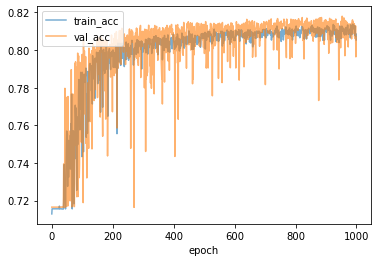

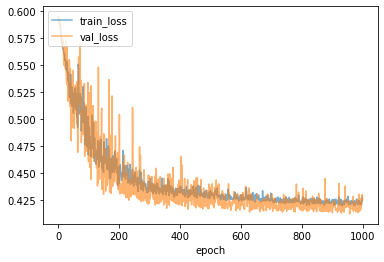

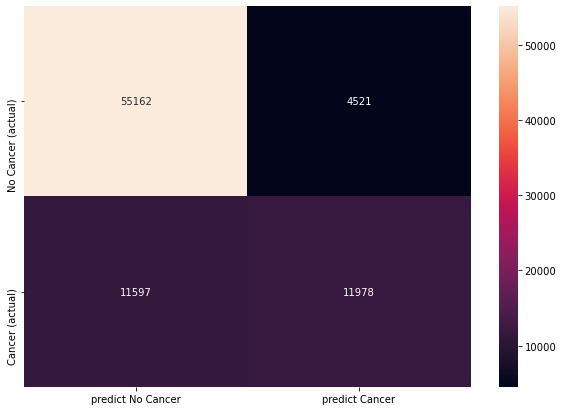

In [47]:
# plot accuracy
plt = acc_plot(history_lr_01)
plt.show()

# plot loss
plt = loss_plot(history_lr_01)
plt.show()

# plot confuction matrix
plt=conf_matrix(model, x_test, y_test)
plt.show()

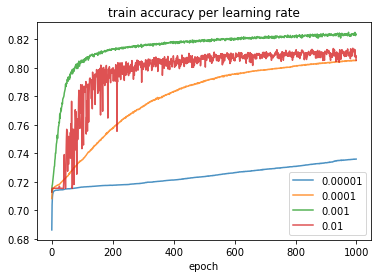

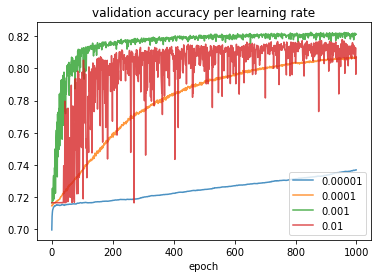

In [26]:
plt.plot(history_lr_00001.history['accuracy'], alpha=.8)

plt.plot(history_lr_0001.history['accuracy'], alpha=.8)

plt.plot(history_lr_001.history['accuracy'], alpha=.8)

plt.plot(history_lr_01.history['accuracy'], alpha=.8)

plt.xlabel('epoch')
plt.legend(['0.00001', '0.0001', '0.001', '0.01'], loc='lower right')
plt.title('train accuracy per learning rate')
plt.show()

plt.plot(history_lr_00001.history['val_accuracy'], alpha=.8)

plt.plot(history_lr_0001.history['val_accuracy'], alpha=.8)

plt.plot(history_lr_001.history['val_accuracy'], alpha=.8)

plt.plot(history_lr_01.history['val_accuracy'], alpha=.8)

plt.xlabel('epoch')
plt.legend(['0.00001', '0.0001', '0.001', '0.01'], loc='lower right')
plt.title('validation accuracy per learning rate')
plt.show()

In [9]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print(F"test loss {results[0]:.2f},\ntest acc: {results[1]:1.2f}")

Evaluate on test data
651/651 [==============================] - 1s 2ms/step - loss: 0.4301 - accuracy: 0.8064
test loss 0.43,
test acc: 0.81


## Results from simple dense net

The simple dense net reaches a accuracy on out test dataset of nearly 72 percent. This sounds respectable for such a simple network. A closer look on our confusion matrix reveals that our network suffers from our imbalanced data and is not able to counter the imbalance and thus classifies nearly all patches as non-cancer.


At this point it is difficult to assess what exactly has to be improved, but we suspect the following issues persist:

1. The Neural Network does not learn enough from the features, most likely the size of the network is insufficient to learn the features. When increasing the number of layers and the size of the layers we will encounter additional challenges:
    - We could be overfitting our data, which we can mitigate by using dropbout layer
    - We could have a vanishing gradient, which can be mitigated by using normalisazion betweek the hidden layers 
2. The network minimizes the loss, since the data is imbalanced it will inherently favor negative classifications. To counter this multiple options are available
    - We could downsample the negative patches or upsample the positive patches , where the latter is preferred since no data is ignored this way.
    - We could apply balanced weights to increase the impact to the loss function for the positive patches. This should result in an equivalent result than the upsampling.

We will takle the two above mentioned issues after each other. Fist we try to increase the model size and tune the hyperparameters to fit the data better and learn the complexity of the input. Second we will apply class weights to tackle specifically the imbalanced data

In [27]:
# lower the number of epochs
epochs = 500

batch_size = 8192
histories = []

name="2-layer-64-128"
print(name)
model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model1.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

histories.append(model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))


name="2-layer-128-256"
print(name)
model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model2.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

histories.append(model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))

name="2-layer-256-512"
print(name)
model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model3.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

histories.append(model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))

name="3-layer-256-512-256"
print(name)
model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model4.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

histories.append(model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))

name="4-layer-2048-1024-512"
print(name)
model5 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model5.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

histories.append(model5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))

name="3-layer-2048-1024-512-norm"
print(name)
model6 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model6.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model6.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))

name="3-layer-2048-1024-512-dropout"
print(name)
model7 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model7.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model7.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))

name="3-layer-2048-1024-512-norm-dropout"
print(name)
model8 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model8.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model8.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))

name="3-layer-4096-2048-1024-norm-dropout"
print(name)
model9 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

model9.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

histories.append(model9.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val,y_val), verbose=0))

2-layer-64-128
2-layer-128-256
2-layer-256-512
3-layer-256-512-256
4-layer-2048-1024-512
3-layer-2048-1024-512-norm
3-layer-2048-1024-512-dropout
3-layer-2048-1024-512-norm-dropout
3-layer-4096-2048-1024-norm-dropout


In [28]:
columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
df_bigger_nets = pd.DataFrame(columns = columns)

for history in histories:
    df_temp = pd.DataFrame([[history.model.name,
                              history.history['loss'][-1],
                              history.history['accuracy'][-1],
                              history.history['val_loss'][-1],
                              history.history['val_accuracy'][-1]]], 
                    columns = columns)
    df_bigger_nets = df_bigger_nets.append(df_temp)

df_bigger_nets = df_bigger_nets.set_index('model size')

df_bigger_nets = df_bigger_nets.style.format({
    'loss': '{:,.2f}'.format,
    'accuracy': '{:,.2%}'.format,
    'val_loss': '{:,.2f}'.format,
    'val_accuracy': '{:,.2%}'.format,
})

df_bigger_nets

,loss,accuracy,val_loss,val_accuracy
model size,,,,
2-layer-64-128,0.60,71.56%,0.60,71.65%
2-layer-128-256,0.60,71.56%,0.60,71.65%
2-layer-256-512,0.60,71.56%,0.60,71.65%
3-layer-256-512-256,0.60,71.56%,0.67,71.65%
4-layer-2048-1024-512,nan,71.56%,nan,71.65%
3-layer-2048-1024-512-norm,0.00,100.00%,2.87,80.91%
3-layer-2048-1024-512-dropout,0.06,97.77%,7.10,74.38%
3-layer-2048-1024-512-norm-dropout,0.06,97.88%,2.67,79.28%
3-layer-4096-2048-1024-norm-dropout,0.04,98.40%,1.55,81.06%


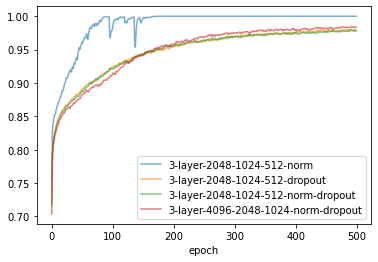

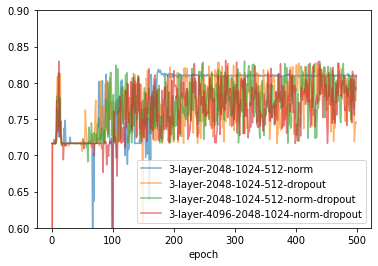

In [43]:
for history in histories[5:]:
    plt.plot(history.history['accuracy'], alpha=.6)
    
plt.xlabel('epoch')
plt.legend([model6.name, model7.name, model8.name, model9.name], loc='lower right')

plt.show()

for history in histories[5:]:
    plt.plot(history.history['val_accuracy'], alpha=.6)
    
plt.xlabel('epoch')
plt.ylim([0.6,0.9])
plt.legend([model6.name, model7.name, model8.name, model9.name], loc='lower right')

plt.show()

In [44]:
histories

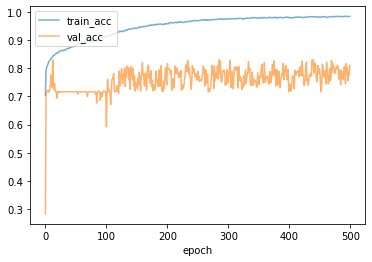

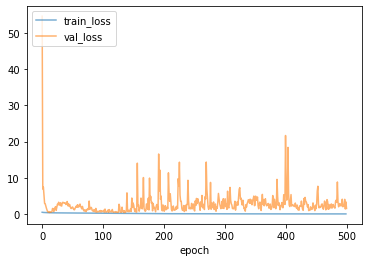

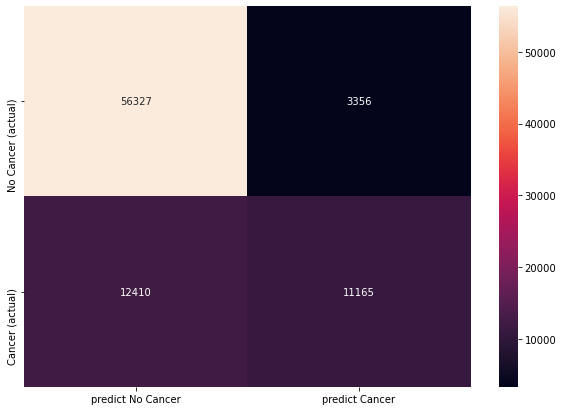

In [48]:
# plot accuracy
plt = acc_plot(histories[-1])
plt.show()

# plot loss
plt = loss_plot(histories[-1])
plt.show()

# plot confuction matrix
plt=conf_matrix(model9, x_test, y_test)
plt.show()

## Learnings
- In the above chart we first of all see that just increasing the number of layers and the number of hidden nodes per layer did not improve the performance. On the contrary we can recognize that in the 3rd network the loss is increasing significantly and and the fourth and fifth layer the loss cannot be displayed. This evidence suggests an exploding/vanishing gradient.
- None of the models are able to reach higher performance for our imbalanced dataset and account for the cancer positive cells
With the different model sizes, learning rates, normalization and dropout layers most issues should have be tackled, so lets run tha above models again with balanced weights, that account for the relative number of positive/negative patches

In [6]:
# lower the number of epochs
epochs = 150

total = np.asarray(y_data).shape[0]
pos = sum(np.asarray(y_data))
neg = total - pos

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
# weight_for_0 = (1 / neg) * (total / 2.0)
# weight_for_1 = (1 / pos) * (total / 2.0)

weight_for_0 = (1 / neg) * total
weight_for_1 = (1 / pos) * total

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

mcp_save = keras.callbacks.ModelCheckpoint('.mdl_wts.hdf5', save_best_only=True, monitor='val_loss', mode='min')

Weight for class 0: 1.40
Weight for class 1: 3.52


In [50]:
batch_size = 8192
balanced_histories = []

name="balanced-2-layer-64-128"
print(name)
balanced_model1 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model1.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-2-layer-64-128.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))


name="balanced-2-layer-128-256"
print(name)
balanced_model2 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model2.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model2.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-2-layer-128-256.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="balanced-2-layer-256-512"
print(name)
balanced_model3 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model3.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model3.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-2-layer-256-512.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="balanced-3-layer-256-512-256"
print(name)
balanced_model4 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model4.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model4.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-3-layer-256-512-256.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="balanced-3-layer-2048-1024-512"
print(name)
balanced_model5 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model5.compile(loss="binary_crossentropy", optimizer=SGD(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model5.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-3-layer-2048-1024-512.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="balanced-3-layer-2048-1024-512-norm"
print(name)
balanced_model6 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model6.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model6.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-3-layer-2048-1024-512-norm.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="balanced-3-layer-2048-1024-512-dropout"
print(name)
balanced_model7 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model7.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model7.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-3-layer-2048-1024-512-dropout.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="balanced-3-layer-2048-1024-512-norm-dropout"
print(name)
balanced_model8 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model8.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model8.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-3-layer-2048-1024-512-norm-dropout.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="balanced-3-layer-4096-2048-1024-norm-dropout"
print(name)
balanced_model9 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model9.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=["accuracy"])

balanced_histories.append(balanced_model9.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[es, keras.callbacks.ModelCheckpoint('balanced-3-layer-4096-2048-1024-norm-dropout.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

balanced-2-layer-64-128
Epoch 1/150
19/19 - 1s - loss: 3606.6943 - accuracy: 0.3380 - val_loss: 0.7175 - val_accuracy: 0.2837
Epoch 2/150
19/19 - 1s - loss: 1.3898 - accuracy: 0.2847 - val_loss: 0.7175 - val_accuracy: 0.2837
Epoch 3/150
19/19 - 1s - loss: 1.3867 - accuracy: 0.2847 - val_loss: 0.7175 - val_accuracy: 0.2837
Epoch 4/150
19/19 - 1s - loss: 1.3867 - accuracy: 0.2847 - val_loss: 0.7175 - val_accuracy: 0.2837
Epoch 5/150
19/19 - 1s - loss: 1.3867 - accuracy: 0.2847 - val_loss: 0.7176 - val_accuracy: 0.2837
Epoch 6/150
19/19 - 1s - loss: 1.3867 - accuracy: 0.2847 - val_loss: 0.7176 - val_accuracy: 0.2837
Epoch 7/150
19/19 - 1s - loss: 1.3867 - accuracy: 0.2847 - val_loss: 0.7176 - val_accuracy: 0.2837
Epoch 8/150
19/19 - 1s - loss: 1.3867 - accuracy: 0.2847 - val_loss: 0.7176 - val_accuracy: 0.2837
Epoch 9/150
19/19 - 1s - loss: 1.3867 - accuracy: 0.2847 - val_loss: 0.7176 - val_accuracy: 0.2837
Epoch 10/150
19/19 - 1s - loss: 1.3867 - accuracy: 0.2847 - val_loss: 0.7176 - val

19/19 - 1s - loss: nan - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.7165
Epoch 18/150
19/19 - 1s - loss: nan - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.7165
Epoch 19/150
19/19 - 1s - loss: nan - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.7165
Epoch 20/150
19/19 - 1s - loss: nan - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.7165
Epoch 21/150
Restoring model weights from the end of the best epoch.
19/19 - 1s - loss: nan - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.7165
Epoch 00021: early stopping
balanced-3-layer-2048-1024-512
Epoch 1/150
19/19 - 2s - loss: nan - accuracy: 0.6453 - val_loss: nan - val_accuracy: 0.7165
Epoch 2/150
19/19 - 2s - loss: nan - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.7165
Epoch 3/150
19/19 - 2s - loss: nan - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.7165
Epoch 4/150
19/19 - 2s - loss: nan - accuracy: 0.7156 - val_loss: nan - val_accuracy: 0.7165
Epoch 5/150
19/19 - 2s - loss: nan - accuracy: 0.7156 - 

Epoch 20/150
19/19 - 2s - loss: 0.7380 - accuracy: 0.8394 - val_loss: 1.0735 - val_accuracy: 0.7173
Epoch 21/150
19/19 - 2s - loss: 0.7295 - accuracy: 0.8404 - val_loss: 0.6300 - val_accuracy: 0.7113
Epoch 22/150
19/19 - 2s - loss: 0.7242 - accuracy: 0.8430 - val_loss: 0.5948 - val_accuracy: 0.7004
Epoch 23/150
19/19 - 2s - loss: 0.7169 - accuracy: 0.8433 - val_loss: 0.6772 - val_accuracy: 0.7239
Epoch 24/150
19/19 - 2s - loss: 0.7130 - accuracy: 0.8449 - val_loss: 0.4927 - val_accuracy: 0.7525
Epoch 25/150
19/19 - 2s - loss: 0.7064 - accuracy: 0.8466 - val_loss: 0.5030 - val_accuracy: 0.7438
Epoch 26/150
19/19 - 2s - loss: 0.7045 - accuracy: 0.8460 - val_loss: 0.7589 - val_accuracy: 0.7231
Epoch 27/150
19/19 - 2s - loss: 0.7022 - accuracy: 0.8478 - val_loss: 0.5089 - val_accuracy: 0.7524
Epoch 28/150
19/19 - 2s - loss: 0.6955 - accuracy: 0.8488 - val_loss: 0.8041 - val_accuracy: 0.7163
Epoch 29/150
Restoring model weights from the end of the best epoch.
19/19 - 2s - loss: 0.6854 - acc

In [51]:
columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
df_bigger_nets = pd.DataFrame(columns = columns)

for history in balanced_histories:
    
    # get the epoch with the highest validation accuracy for each history element
    i = 0
    index = 0
    comp = 0
    for val_acc in history.history['val_accuracy']:
        if val_acc > comp:
            comp = val_acc
            i = index
        index += 1
    
    df_temp = pd.DataFrame([[history.model.name,
                              history.history['loss'][i],
                              history.history['accuracy'][i],
                              history.history['val_loss'][i],
                              history.history['val_accuracy'][i]]], 
                    columns = columns)
    df_bigger_nets = df_bigger_nets.append(df_temp)

df_bigger_nets = df_bigger_nets.set_index('model size')

df_bigger_nets = df_bigger_nets.style.format({
    'loss': '{:,.2f}'.format,
    'accuracy': '{:,.2%}'.format,
    'val_loss': '{:,.2f}'.format,
    'val_accuracy': '{:,.2%}'.format,
})

df_bigger_nets

,loss,accuracy,val_loss,val_accuracy
model size,,,,
balanced-2-layer-64-128,"3,606.69",33.80%,0.72,28.37%
balanced-2-layer-128-256,"11,532,711,755,776.00",51.19%,0.69,71.65%
balanced-2-layer-256-512,"372,137,481,241,206,739,435,520.00",53.34%,"21,577.17",71.65%
balanced-3-layer-256-512-256,nan,62.58%,nan,71.65%
balanced-3-layer-2048-1024-512,nan,64.53%,nan,71.65%
balanced-3-layer-2048-1024-512-norm,0.64,86.13%,0.52,79.47%
balanced-3-layer-2048-1024-512-dropout,0.83,81.58%,0.43,81.63%
balanced-3-layer-2048-1024-512-norm-dropout,0.86,81.21%,0.43,80.91%
balanced-3-layer-4096-2048-1024-norm-dropout,0.84,81.59%,0.43,82.32%


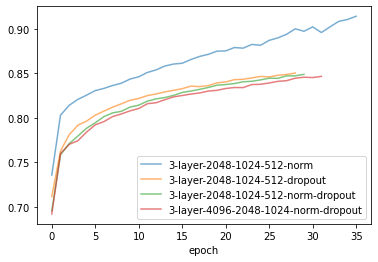

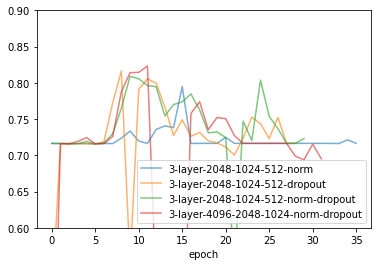

In [58]:
for history in balanced_histories[5:]:
    plt.plot(history.history['accuracy'], alpha=.6)
    
plt.xlabel('epoch')
plt.legend([model6.name, model7.name, model8.name, model9.name], loc='lower right')

plt.show()

for history in balanced_histories[5:]:
    plt.plot(history.history['val_accuracy'], alpha=.6)
    
plt.xlabel('epoch')
plt.ylim([0.6,0.9])
plt.legend([model6.name, model7.name, model8.name, model9.name], loc='lower right')

plt.show()

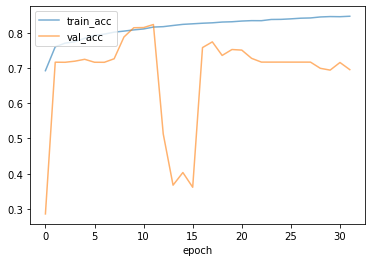

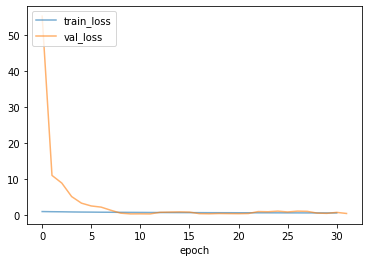

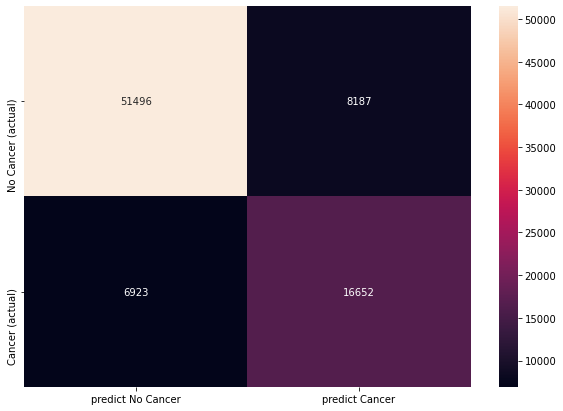

In [52]:
# plot accuracy
plt1 = acc_plot(balanced_histories[-1])
plt.show()

# plot loss
plt2 = loss_plot(balanced_histories[-1])
plt.show()


loaded_model = keras.models.load_model('balanced-3-layer-4096-2048-1024-norm-dropout.hdf5')

# plot confuction matrix
plt=conf_matrix(loaded_model, x_test, y_test)
plt.show()

## Learnings
- The confusion matrix starts to look better, malicious cells are now classified much less as non-malicious than before
- In the graph above we see that the validation accuracy and loss is decreasing/increasing towards the end
- Train accuracy is now much closer to the validation accuracy (at least for the best epoch) over time they still diverge

Since the training and validatio accuracy are close we can reduce the dropout rate, but at the same time we will add an imageDataGenerator to hopefully increase generalizability of our model.On top we define a learning rate schedule that reduces when a plateau is reached and change all optimizations to from stochastig gradient descent to the adam optimizer.

Since the smaller networks needed more epochs to show improvements we remove the early stopping criterion for those and increase the patience for the rest, to make sure not to stop too early

In [61]:
#Early stopping callback
es = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, verbose=2,
                                      mode='max', baseline=None, restore_best_weights=True)

#Image Data Augmentation

train_generator = ImageDataGenerator(rotation_range=90, horizontal_flip=True, vertical_flip=True)

test_generator = ImageDataGenerator(rotation_range=90, horizontal_flip=True, vertical_flip=True)

val_generator = ImageDataGenerator(rotation_range=90, horizontal_flip=True, vertical_flip=True)

train_generator.fit(x_train)
test_generator.fit(x_test)
val_generator.fit(x_val)

#Learning Rate Annealer
lrr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                       factor=.1,
                       patience=9,
                       min_lr=1e-6,
                       verbose=2)

In [62]:
batch_size = 8192
callback_balanced_histories = []

name="callback-balanced-2-layer-64-128"
print(name)
balanced_model01 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model01.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model01.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, keras.callbacks.ModelCheckpoint('callback-balanced-2-layer-64-128.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))


name="callback-balanced-2-layer-128-256"
print(name)
balanced_model02 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model02.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model02.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, keras.callbacks.ModelCheckpoint('callback-balanced-2-layer-128-256.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="callback-balanced-2-layer-256-512"
print(name)
balanced_model03 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model03.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model03.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, keras.callbacks.ModelCheckpoint('callback-balanced-2-layer-256-512.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="callback-balanced-3-layer-256-512-256"
print(name)
balanced_model04 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model04.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model04.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, es, keras.callbacks.ModelCheckpoint('callback-balanced-3-layer-256-512-256.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="callback-balanced-3-layer-2048-1024-512"
print(name)
balanced_model05 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model05.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model05.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, es, keras.callbacks.ModelCheckpoint('callback-balanced-3-layer-2048-1024-512.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="callback-balanced-3-layer-2048-1024-512-norm"
print(name)
balanced_model06 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model06.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model06.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, es, keras.callbacks.ModelCheckpoint('callback-balanced-3-layer-2048-1024-512-norm.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="callback-balanced-3-layer-2048-1024-512-dropout"
print(name)
balanced_model07 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model07.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model07.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, es, keras.callbacks.ModelCheckpoint('callback-balanced-3-layer-2048-1024-512-dropout.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="callback-balanced-3-layer-2048-1024-512-norm-dropout"
print(name)
balanced_model08 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model08.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model08.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, es, keras.callbacks.ModelCheckpoint('callback-balanced-3-layer-2048-1024-512-norm-dropout.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

name="callback-balanced-3-layer-4096-2048-1024-norm-dropout"
print(name)
balanced_model09 = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Flatten(),        
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(2048, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1024, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ],name=name
)

balanced_model09.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.01), metrics=["accuracy"])

callback_balanced_histories.append(balanced_model09.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                            validation_data=(x_val,y_val), verbose=2, class_weight=class_weight,
                                    callbacks=[lrr, es, keras.callbacks.ModelCheckpoint('callback-balanced-3-layer-4096-2048-1024-norm-dropout.hdf5',
                                                                                   save_best_only=True,
                                                                                   monitor='val_loss',
                                                                                   mode='min')]))

callback-balanced-2-layer-64-128
Epoch 1/150
19/19 - 1s - loss: 4224.7334 - accuracy: 0.5090 - val_loss: 272.0714 - val_accuracy: 0.7165
Epoch 2/150
19/19 - 1s - loss: 272.9232 - accuracy: 0.5111 - val_loss: 20.1883 - val_accuracy: 0.7165
Epoch 3/150
19/19 - 1s - loss: 417.2967 - accuracy: 0.5125 - val_loss: 0.7188 - val_accuracy: 0.2835
Epoch 4/150
19/19 - 1s - loss: 1.3893 - accuracy: 0.2844 - val_loss: 0.6973 - val_accuracy: 0.2835
Epoch 5/150
19/19 - 1s - loss: 1.3871 - accuracy: 0.6479 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 6/150
19/19 - 1s - loss: 1.3871 - accuracy: 0.2844 - val_loss: 0.6929 - val_accuracy: 0.7165
Epoch 7/150
19/19 - 1s - loss: 1.3871 - accuracy: 0.4644 - val_loss: 0.6940 - val_accuracy: 0.2835
Epoch 8/150
19/19 - 1s - loss: 1.3871 - accuracy: 0.6023 - val_loss: 0.6960 - val_accuracy: 0.2835
Epoch 9/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.3064 - val_loss: 0.6926 - val_accuracy: 0.7165
Epoch 10/150

Epoch 00010: ReduceLROnPlateau reducing learning rat

Epoch 80/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 81/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 82/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 83/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 84/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 85/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 86/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 87/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 88/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 89/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835



Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 12/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 13/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 14/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 15/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 16/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 17/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 18/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 19/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 20/150

Epoch 00020: Reduc

Epoch 90/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 91/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 92/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 93/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 94/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 95/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 96/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 97/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 98/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835
Epoch 99/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6937 - val_accuracy: 0.2835


Epoch 21/150

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6934 - val_accuracy: 0.2835
Epoch 22/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6934 - val_accuracy: 0.2835
Epoch 23/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6935 - val_accuracy: 0.2835
Epoch 24/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 25/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6935 - val_accuracy: 0.2835
Epoch 26/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 27/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 28/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6935 - val_accuracy: 0.2835
Epoch 29/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 30/150

Epoch

Epoch 101/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 102/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 103/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 104/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 105/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 106/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 107/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 108/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 109/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accuracy: 0.2835
Epoch 110/150
19/19 - 1s - loss: 1.3870 - accuracy: 0.2844 - val_loss: 0.6936 - val_accurac

Epoch 32/150
19/19 - 1s - loss: 0.9625 - accuracy: 0.7830 - val_loss: 0.4727 - val_accuracy: 0.7901
Epoch 33/150

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
19/19 - 1s - loss: 0.9630 - accuracy: 0.7833 - val_loss: 0.4750 - val_accuracy: 0.7890
Epoch 34/150
19/19 - 1s - loss: 0.9622 - accuracy: 0.7842 - val_loss: 0.4838 - val_accuracy: 0.7842
Epoch 35/150
19/19 - 1s - loss: 0.9622 - accuracy: 0.7820 - val_loss: 0.4752 - val_accuracy: 0.7886
Epoch 36/150
19/19 - 1s - loss: 0.9621 - accuracy: 0.7831 - val_loss: 0.4833 - val_accuracy: 0.7845
Epoch 37/150
19/19 - 1s - loss: 0.9621 - accuracy: 0.7821 - val_loss: 0.4796 - val_accuracy: 0.7862
Epoch 38/150
19/19 - 1s - loss: 0.9620 - accuracy: 0.7821 - val_loss: 0.4817 - val_accuracy: 0.7853
Epoch 39/150
19/19 - 1s - loss: 0.9620 - accuracy: 0.7824 - val_loss: 0.4824 - val_accuracy: 0.7848
Epoch 40/150
19/19 - 1s - loss: 0.9620 - accuracy: 0.7820 - val_loss: 0.4781 - val_accuracy: 0.7869
Epoch 41/150
19/19 

Epoch 9/150
19/19 - 3s - loss: 0.8141 - accuracy: 0.8140 - val_loss: 1.9618 - val_accuracy: 0.7164
Epoch 10/150
19/19 - 2s - loss: 0.7934 - accuracy: 0.8200 - val_loss: 2.4550 - val_accuracy: 0.7165
Epoch 11/150
19/19 - 2s - loss: 0.7812 - accuracy: 0.8230 - val_loss: 2.1340 - val_accuracy: 0.7161
Epoch 12/150
19/19 - 2s - loss: 0.7652 - accuracy: 0.8272 - val_loss: 2.3716 - val_accuracy: 0.7164
Epoch 13/150

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0009999999776482583.
19/19 - 3s - loss: 0.7566 - accuracy: 0.8266 - val_loss: 1.0406 - val_accuracy: 0.7168
Epoch 14/150
19/19 - 4s - loss: 0.7332 - accuracy: 0.8351 - val_loss: 0.7145 - val_accuracy: 0.7285
Epoch 15/150
19/19 - 3s - loss: 0.7216 - accuracy: 0.8361 - val_loss: 0.5938 - val_accuracy: 0.7556
Epoch 16/150
19/19 - 3s - loss: 0.7181 - accuracy: 0.8375 - val_loss: 0.4750 - val_accuracy: 0.7924
Epoch 17/150
19/19 - 4s - loss: 0.7145 - accuracy: 0.8381 - val_loss: 0.4160 - val_accuracy: 0.8113
Epoch 18/150
19/19 -

Epoch 25/150
19/19 - 2s - loss: 0.7186 - accuracy: 0.8368 - val_loss: 0.5564 - val_accuracy: 0.7598
Epoch 26/150
19/19 - 2s - loss: 0.7089 - accuracy: 0.8403 - val_loss: 0.5159 - val_accuracy: 0.7778
Epoch 27/150
19/19 - 2s - loss: 0.7097 - accuracy: 0.8396 - val_loss: 0.5113 - val_accuracy: 0.7837
Epoch 28/150
19/19 - 2s - loss: 0.7041 - accuracy: 0.8408 - val_loss: 0.4925 - val_accuracy: 0.7931
Epoch 29/150
19/19 - 2s - loss: 0.7015 - accuracy: 0.8417 - val_loss: 0.4665 - val_accuracy: 0.8028
Epoch 30/150
19/19 - 2s - loss: 0.7030 - accuracy: 0.8410 - val_loss: 0.4720 - val_accuracy: 0.8059
Epoch 31/150
19/19 - 2s - loss: 0.6993 - accuracy: 0.8424 - val_loss: 0.4556 - val_accuracy: 0.8119
Epoch 32/150
19/19 - 2s - loss: 0.6976 - accuracy: 0.8423 - val_loss: 0.4973 - val_accuracy: 0.8104
Epoch 33/150

Epoch 00033: ReduceLROnPlateau reducing learning rate to 9.999999310821295e-05.
19/19 - 2s - loss: 0.6950 - accuracy: 0.8444 - val_loss: 0.4914 - val_accuracy: 0.8118
Epoch 34/150
19/19 

Epoch 46/150
19/19 - 2s - loss: 0.7012 - accuracy: 0.8409 - val_loss: 0.4285 - val_accuracy: 0.8061
Epoch 47/150
19/19 - 2s - loss: 0.7018 - accuracy: 0.8408 - val_loss: 0.4263 - val_accuracy: 0.8071
Epoch 48/150
19/19 - 2s - loss: 0.7023 - accuracy: 0.8410 - val_loss: 0.4256 - val_accuracy: 0.8074
Epoch 49/150
19/19 - 2s - loss: 0.7029 - accuracy: 0.8404 - val_loss: 0.4260 - val_accuracy: 0.8076
Epoch 50/150

Epoch 00050: ReduceLROnPlateau reducing learning rate to 1e-06.
19/19 - 2s - loss: 0.7035 - accuracy: 0.8402 - val_loss: 0.4263 - val_accuracy: 0.8071
Epoch 51/150
19/19 - 2s - loss: 0.7017 - accuracy: 0.8410 - val_loss: 0.4256 - val_accuracy: 0.8077
Epoch 52/150
19/19 - 2s - loss: 0.7031 - accuracy: 0.8397 - val_loss: 0.4252 - val_accuracy: 0.8078
Epoch 53/150
19/19 - 2s - loss: 0.7013 - accuracy: 0.8409 - val_loss: 0.4247 - val_accuracy: 0.8080
Epoch 54/150
Restoring model weights from the end of the best epoch.
19/19 - 2s - loss: 0.7037 - accuracy: 0.8399 - val_loss: 0.4243 - 

Epoch 70/150
19/19 - 7s - loss: 0.7190 - accuracy: 0.8354 - val_loss: 0.4091 - val_accuracy: 0.8171
Epoch 71/150
19/19 - 7s - loss: 0.7199 - accuracy: 0.8354 - val_loss: 0.4085 - val_accuracy: 0.8174
Epoch 72/150
19/19 - 6s - loss: 0.7194 - accuracy: 0.8349 - val_loss: 0.4081 - val_accuracy: 0.8174
Epoch 73/150
19/19 - 4s - loss: 0.7181 - accuracy: 0.8356 - val_loss: 0.4088 - val_accuracy: 0.8169
Epoch 74/150
19/19 - 4s - loss: 0.7196 - accuracy: 0.8353 - val_loss: 0.4088 - val_accuracy: 0.8170
Epoch 75/150
19/19 - 4s - loss: 0.7165 - accuracy: 0.8356 - val_loss: 0.4087 - val_accuracy: 0.8173
Epoch 76/150
19/19 - 4s - loss: 0.7185 - accuracy: 0.8349 - val_loss: 0.4098 - val_accuracy: 0.8164
Epoch 77/150
19/19 - 4s - loss: 0.7202 - accuracy: 0.8351 - val_loss: 0.4095 - val_accuracy: 0.8165
Epoch 78/150
19/19 - 4s - loss: 0.7195 - accuracy: 0.8353 - val_loss: 0.4096 - val_accuracy: 0.8165
Epoch 79/150
19/19 - 4s - loss: 0.7181 - accuracy: 0.8358 - val_loss: 0.4091 - val_accuracy: 0.8168


In [68]:
columns = ['model size' ,'loss', 'accuracy', 'val_loss', 'val_accuracy']
df_bigger_nets = pd.DataFrame(columns = columns)

for history in callback_balanced_histories:
    
    # get the epoch with the highest validation accuracy for each history element
    i = 0
    index = 0
    comp = 0
    for val_acc in history.history['val_accuracy']:
        if val_acc > comp:
            comp = val_acc
            i = index
        index += 1
    
    df_temp = pd.DataFrame([[history.model.name,
                              history.history['loss'][i],
                              history.history['accuracy'][i],
                              history.history['val_loss'][i],
                              history.history['val_accuracy'][i]]], 
                    columns = columns)
    df_bigger_nets = df_bigger_nets.append(df_temp)

df_bigger_nets = df_bigger_nets.set_index('model size')

df_bigger_nets = df_bigger_nets.style.format({
    'loss': '{:,.2f}'.format,
    'accuracy': '{:,.2%}'.format,
    'val_loss': '{:,.2f}'.format,
    'val_accuracy': '{:,.2%}'.format,
})

print('Epochs with the best validation accuracy')
df_bigger_nets

Epochs with the best validation accuracy


,loss,accuracy,val_loss,val_accuracy
model size,,,,
callback-balanced-2-layer-64-128,"4,224.73",50.90%,272.07,71.65%
callback-balanced-2-layer-128-256,96.62,48.85%,62.38,71.65%
callback-balanced-2-layer-256-512,1.39,46.65%,0.68,71.65%
callback-balanced-3-layer-256-512-256,1.03,78.33%,0.44,80.40%
callback-balanced-3-layer-2048-1024-512,993.75,50.93%,137.70,71.65%
callback-balanced-3-layer-2048-1024-512-norm,0.70,84.08%,0.40,83.30%
callback-balanced-3-layer-2048-1024-512-dropout,0.80,81.81%,0.43,81.99%
callback-balanced-3-layer-2048-1024-512-norm-dropout,0.80,81.57%,0.40,83.70%
callback-balanced-3-layer-4096-2048-1024-norm-dropout,0.72,83.54%,0.41,81.74%


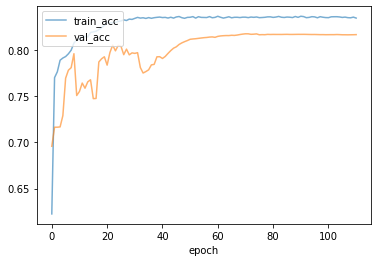

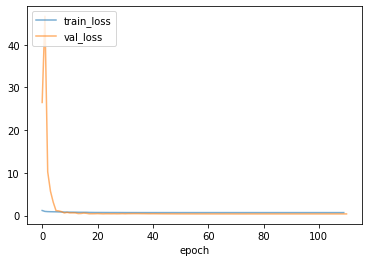

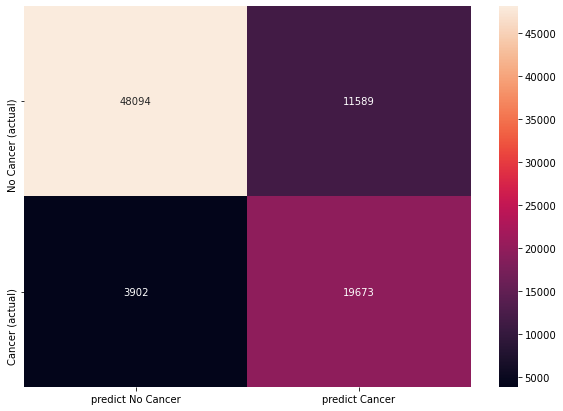

In [73]:
# plot accuracy
plt1 = acc_plot(callback_balanced_histories[-1])
plt.show()

# plot loss
plt2 = loss_plot(callback_balanced_histories[-1])
plt.show()

loaded_model = keras.models.load_model('callback-balanced-3-layer-4096-2048-1024-norm-dropout.hdf5')

# plot confuction matrix
plt=conf_matrix(loaded_model, x_test, y_test)
plt.show()

# Results

The final model does not seem to be far superior to previous ones if we observe the accuracy and the loss. It has one of the best performances if we measure validation loss and accuracy, but the first model with the learning rate 0.01 reached a similar performance according to those measures.
Since we are building a model for medical diagnosis, accuracy and loss are not neccessarily the most important measures (even though it makes sense to optimize them). including the confusion matrix in our model evaluation shows that we are constantly improving on predicting malicious cells and also minimize the classification of malicious cells as harmless, a missclassification, which could have severe implications for the patient.

Increasing the size of the model to a certain size, adding dropout and normalization layers, countering the imbalance of the data with balanced weights as well as applying a learning rate schedule improved the result significantly.

